## Project Milestone 2 findings (scroll down for PM3 findings)

### Imports

In [ ]:
import sys
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import math
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import importlib
from empath import Empath

#add path to script
sys.path.append(os.path.abspath("../src/data/"))
sys.path.append(os.path.abspath("src/model/"))
sys.path.append(os.path.abspath("../src/plots_helper/"))
sys.path.append(os.path.abspath("src/utils/"))

from src.model.ARDL_model import *
from src.utils.helper import *
from src.plot_helper.ARDL_plot_helper import *
#import the DataLoader class
from src.data.data_loading import DataLoader


%matplotlib inline

# Table of Contents  
- [0. Data Cleaning](#datacleaning)
    - [0.1 Movie Data](#moviedata)
        - [0.1.1 CMU Data](#cmu_data)
        - [0.1.2 Kaggle](#kaggle_data)
        - [0.1.3 Use of Kaggle Data to mitigate issues of CMU Data](#fusionkagglecmu)
        - [0.1.4 Human labelled Data ](#humanlabeldata)
    - [0.2 Real life Data](#reallifedata)
   

- [1. Characterisation of movies violence](#movieanalysis)
    - [1.1. Violent words](#violentwords)
        - [1.1.1 Generic violent words extraction](#genericviolentwords)
        - [1.2.1 Specific violent words extraction](#specificviolentwords)
        - [1.2.2 Violent words analysis](#violentwordsanalysis)
    - [1.2 Sentimental analysis](#sentiment)

- [2. Movies classification](#movieclass)
    - [2.1 Regression model](#regression)
    - [2.2 LLM classification: mutliclass (non-violent, mid-violent, violent)](#multiclass)
        - [2.2.1 Data preparation for LLM](#dataprepllm)
        - [2.2.2 Choice of LLM-GPT-4-mini](#llmgpt4mini)
        - [2.2.3 Prompt engineering](#prompt)
        - [2.2.4 Tokens number verification](#tokens)
        - [2.2.5 Batch creation](#batch)
        - [2.2.6 LLM classification assesment](#llmclass)
        - [2.2.7 Application on whole movie data](#whole)
        
    - [2.3 LLM classification : binary (non-violent, violent)](#binary)
       

- [3. Characterisation of classified violent movies](#characterisationvalidation)
    - [3.1 Plot categorisation using Empath](#empath)
    - [3.2 Sentimental analysis](#sentiment)
        - [3.2.1 Validation of mutliclass classification](#validationmutliclass)
        - [3.2.2 Validation of binary classification](#validationbinary)

    - [3.3 Time trends](#timetrends)
    - [3.4 Genres](#genres)

- [4. Proxy to reflect movie importance: box office](#boxoffice)

- [5. Characterisation of real-life violence](#reallifeviolence)
    - [5.1 Violent scores](#violentscores)
    - [5.2 Potential cofounding factors](#cofounding)

- [6. Impact of violent movies on real life violence : autoregressive distributed lag model](#ardl)
    


<h1 style="color: blue;">0. Data Cleaning  </h1> <a id="datacleaning"></a>

This first part of the notebook shows all the data cleaning steps. It has to be run once to obtain the cleaned data.

<h1 style="color: blue;">0.1 Movie Data </h1> <a id="moviedata"></a>

For our analysis, we will need 2 movie datasets: CMU Movies Dataset & Kaggle Movies Dataset. \
\
<b>Why 2 datasets ?</b> \
\
For our purpose, we need movie data and corresponding movie plots (CMU movie metadata & CMU plot summaries respectively). We will then restrict the analysis to American movies, leaving us with approximately half of the original dataset — 20,788 movies. \
Since our aim is to assess the correlation of the data with historical events, the release date is really important. We want to have the precise date, not just the year. However, dropping all rows where the date is not precise will cause us to lose a lot of data, as only 13,335 movies have precise dates. This is where the Kaggle dataset comes in. When the date is not precise, we will try to match the movie with the corresponding from this dataset and extract its date. Using this method, we recover a lot of data and end up with 17,077 movies.

<b>Data preprocessing steps</b> \
We will apply the following pipeline:

<ul>
    <li>load CMU, plots and Kaggle datasets </li>
    <li>CMU data preprocessing</li><ul>
        <li>Remove unnecessary columns</li>
        <li>Check for NaN values in plots</li>
        <li>Merge CMU metadata and plots on Wikipedia ID — take only movies present in both</li>
        <li>Convert plots to lowercase</li>
        <li>Put each column of the movie metadata in the wanted format. For example, {"/m/09c7w0": "United States of America"} should become "United States of America"</li>
        <li>Keep only American movies</li>
    </ul>
    <li>Kaggle data preprocessing</li><ul>
        <li>Remove unnecessary columns</li>
        <li>Put each column of the movie metadata in the correct format. For example, {"/m/09c7w0": "United States of America"} should become "United States of America"</li>
        <li>Keep only American movies</li>
        <li>Drop NaN values and duplicated rows (if present)</li>
    </ul>
    <li>For incomplete or missing dates, merge with the Kaggle dataset using the movie title, and ultimately the date</li>
    <li>Check for outliers (e.g., incorrect dates)</li>
    <li>Save the cleaned dataset</li>
</ul>

In [1]:
# Paths to the data folder
raw = 'data/RAW/'
clean = 'data/CLEAN'

In [4]:
# Loader (see data_loading.py for the code regarding this function)
data_loader = DataLoader(raw,clean)
# Load raw data
CMU_movie_metadata, CMU_plot_summary, GVD_data, Kaggle_movies_metadata = data_loader.load_all_data()


load CMU movie metadata


load plot data


load GVD data


load kaggle movie data



<h2 style="color: blue;"> 0.1.1 CMU metadata </h2>

In [5]:
# Let's have a look at the raw CMU metadata first
CMU_movie_metadata.head(3)

,Freebase movie ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
Wikipedia movie ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."


In [6]:
# We will also have a look at the raw CMU plot summaries
CMU_plot_summary.head(3)

,Plot
Wikipedia movie ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...


In [7]:
# Drop unnecessary columns in metadata
CMU_movie_metadata.drop(['Freebase movie ID', 'Runtime'], axis=1,inplace=True)

In [8]:
# Check for NAN in the plots
CMU_plot_summary[CMU_plot_summary["Plot"].isna()]

,Plot
Wikipedia movie ID,


In [9]:
# Merge the two datasets
Movie_Data = CMU_movie_metadata.merge(CMU_plot_summary,left_index=True, right_index=True, how='inner')

In [10]:
# Lower case the plot_summaries
Movie_Data['Plot'] = Movie_Data['Plot'].str.lower()

In [11]:
for name in ['Genres','Countries','Languages'] :
    Movie_Data[name] = Movie_Data[name].apply(extract_data)

In [12]:
# Look for where our movies come from
Movie_Data["Countries"].value_counts().head(10)

Countries
United States of America                    17774
India                                        4628
                                             3312
United Kingdom                               2284
Japan                                        1157
France                                        847
Canada                                        663
South Korea                                   650
United States of America, United Kingdom      614
Hong Kong                                     544
Name: count, dtype: int64

Regarding the countries: we conclude that the majority of CMU movies comes from the US. Hence, we will restrict our analysis to the real world violence in the US, to then correlate it to the movies produced in this country in a relative period of time. Our plan is to investigate both the influence in movie violence on real world crimes and the influence of major violents events in history on "on screen" violence. 

In [13]:
# Keep only American movies
Movie_Data = Movie_Data[Movie_Data['Countries'].str.contains("United States of America", na=False)]

In [14]:
# Look at the shape before any drop for dates
Movie_Data.shape
print("There are {} movies in the CMU dataset prior any preprocessing".format(Movie_Data.shape[0]))

There are 20788 movies in the CMU dataset prior any preprocessing


In [15]:
# Find all movies where the date format is incomplete
Movie_Data_date_wrong = Movie_Data[~Movie_Data['Release date'].str.match(r'^\d{4}-\d{2}-\d{2}$', na=False)]

In [16]:
# Number of remaining datapoints if we drop all rows where the date format is incomplete
Movie_Data.shape[0]-Movie_Data_date_wrong.shape[0]
print("Number of movies with a complete date format: {}".format(Movie_Data.shape[0]-Movie_Data_date_wrong.shape[0]))

Number of movies with a complete date format: 13335


Uhm, not that many movies are left. Thus, let's turn to the Kaggle dataset to solve this issue. 

<h3 style="color: blue;">0.1.2 Kaggle metadata</h3> <a id="kaggle_data"></a>

In [17]:
# Let's have a look at the data
Kaggle_movies_metadata.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [18]:
# Keep only the rows of interest
Kaggle_movies_metadata = Kaggle_movies_metadata[["production_countries","release_date","title"]]

In [19]:
# Check again the countries of production (spoiler: it's again the US)
Kaggle_movies_metadata['production_countries'].value_counts().head(10)

production_countries
[{'iso_3166_1': 'US', 'name': 'United States of America'}]    17851
[]                                                             6282
[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]               2238
[{'iso_3166_1': 'FR', 'name': 'France'}]                       1654
[{'iso_3166_1': 'JP', 'name': 'Japan'}]                        1356
[{'iso_3166_1': 'IT', 'name': 'Italy'}]                        1030
[{'iso_3166_1': 'CA', 'name': 'Canada'}]                        840
[{'iso_3166_1': 'DE', 'name': 'Germany'}]                       749
[{'iso_3166_1': 'RU', 'name': 'Russia'}]                        735
[{'iso_3166_1': 'IN', 'name': 'India'}]                         735
Name: count, dtype: int64

In [20]:

# Extract country of production for the Kaggle dataset
def extract_country(text):
    final_countries = ""
    countries = ast.literal_eval(Kaggle_movies_metadata.production_countries[0])
    for country in countries :
        final_countries = final_countries + " " + country['name']
    return final_countries 

Kaggle_movies_metadata.loc[:, 'production_countries'] = Kaggle_movies_metadata['production_countries'].apply(extract_country)

In [21]:
# Keep only American movies
Kaggle_movies_metadata = Kaggle_movies_metadata[Kaggle_movies_metadata['production_countries'].str.contains("United States of America", na=False)]
print("The resulting length of the Kaggle movies, when keeping only american is {}.".format(len(Kaggle_movies_metadata)))

The resulting length of the Kaggle movies, when keeping only american is 45466.


In [22]:
# Drop NAN values
Kaggle_movies_metadata.dropna(inplace=True)
print("The resulting length of the Kaggle movies, when deleting nan values is {}.".format(len(Kaggle_movies_metadata.shape)))

The resulting length of the Kaggle movies, when deleting nan values is 2.


In [23]:
# Drop full duplicates
Kaggle_movies_metadata.drop_duplicates()
print("The resulting length of the Kaggle movies, when deleting duplicates is {}.".format(len(Kaggle_movies_metadata)))

The resulting length of the Kaggle movies, when deleting duplicates is 45376.



<h3 style="color:blue;">0.1.3 Use of Kaggle Data to mitigate issues of CMU Data </h3><a id="fusionkagglecmu"></a>
Now that we have our two datasets, we can handle the date & duplicates problems

In [24]:
# An example
Movie_Data[Movie_Data["Movie name"] == "Dr. Jekyll and Mr. Hyde"]

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
7884497,Dr. Jekyll and Mr. Hyde,1913-03-06,NaN,English Language,United States of America,"Short Film, Science Fiction, Horror, Black-and...","dr. henry jekyll sends a note to his fiancée,..."
7883633,Dr. Jekyll and Mr. Hyde,1920-04,NaN,"Silent film, English Language",United States of America,"Silent film, Horror, Indie, Science Fiction, B...",at the first transformation starts with jekyll...
144774,Dr. Jekyll and Mr. Hyde,1931-12-31,NaN,English Language,United States of America,"Science Fiction, Horror, Black-and-white, Dram...","the film tells the story of dr. henry jekyll ,..."
3672796,Dr. Jekyll and Mr. Hyde,1920-03-18,NaN,"Silent film, English Language",United States of America,"Crime Fiction, Silent film, Horror, Science Fi...","henry jekyll is a doctor of medicine, but he ..."
2490751,Dr. Jekyll and Mr. Hyde,1941-08-12,1279000.0,English Language,United States of America,"Science Fiction, Horror, Black-and-white",dr. jekyll believes good and evil exist in ev...
7870349,Dr. Jekyll and Mr. Hyde,1908-03-07,NaN,Silent film,United States of America,"Short Film, Silent film, Horror, Indie, Black-...",dr. jekyll and mr. hyde began with the raising...
7856323,Dr. Jekyll and Mr. Hyde,1912-01-16,NaN,English Language,United States of America,"Short Film, Horror, Black-and-white",james cruze's white-haired dr. jekyll has secr...


In [25]:
Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == "Dr. Jekyll and Mr. Hyde"]

,production_countries,release_date,title
7055,United States of America,1941-08-12,Dr. Jekyll and Mr. Hyde
7823,United States of America,1931-12-31,Dr. Jekyll and Mr. Hyde
8294,United States of America,1920-03-18,Dr. Jekyll and Mr. Hyde
25134,United States of America,2008-05-17,Dr. Jekyll and Mr. Hyde


As we can see, some names are similar in both datasets, but there is no duplicate. They are different movies. \
We will take that into account for the date algorithm. 

In [26]:
# Iter on all rows of the wrong date dataset
for index, row in Movie_Data_date_wrong.iterrows() :
    # Is it in the Kaggle dataset ?
    kaggle_data = Kaggle_movies_metadata[Kaggle_movies_metadata["title"] == row["Movie name"]]
    
    # If not, drop the row
    if kaggle_data.empty :
        #print("drop")
        Movie_Data.drop([index], inplace=True)

    # If yes and only one, extract the date
    elif kaggle_data.shape[0] == 1 :
        #print("change")
        Movie_Data.loc[index,"Release date"] = kaggle_data.iloc[0]["release_date"]

    # If multiple movies have this name in the Kaggle dataset, compare with the incomplete date of the CMU dataset
    else :
        date = Movie_Data_date_wrong.loc[index, "Release date"]

        # If not the same year and not the year in the CMU, drop
        if pd.isna(date) or len(date) < 4 :
            Movie_Data.drop([index],inplace=True)

        # Else, compare
        else :
            kaggle_data = kaggle_data[kaggle_data['release_date'].str[:4] == date[0:4]]

            # Found only 1 movie this year ? extract the date !
            if kaggle_data.shape[0] == 1 :
                #print("found!")
                Movie_Data.loc[index,"Release date"] = kaggle_data.iloc[0]["release_date"]

            # Give up
            else :
                #print("sad..")
                Movie_Data.drop([index], inplace=True)

In [27]:
Movie_Data.head(3)
# Nice we kept 4000 more data !

,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
Wikipedia movie ID,,,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th..."
6631279,Little city,1997-04-04,NaN,English Language,United States of America,"Romantic comedy, Ensemble Film, Comedy-drama, ...","adam, a san francisco-based artist who works a..."
77856,Mary Poppins,1964-08-27,102272727.0,English Language,United States of America,"Children's/Family, Musical, Fantasy, Comedy, D...",the film opens with mary poppins perched in a...


In [28]:
# We are thus left with:
print("We are thus left with: {} movies.".format(len(Movie_Data)))

We are thus left with: 17077 movies.


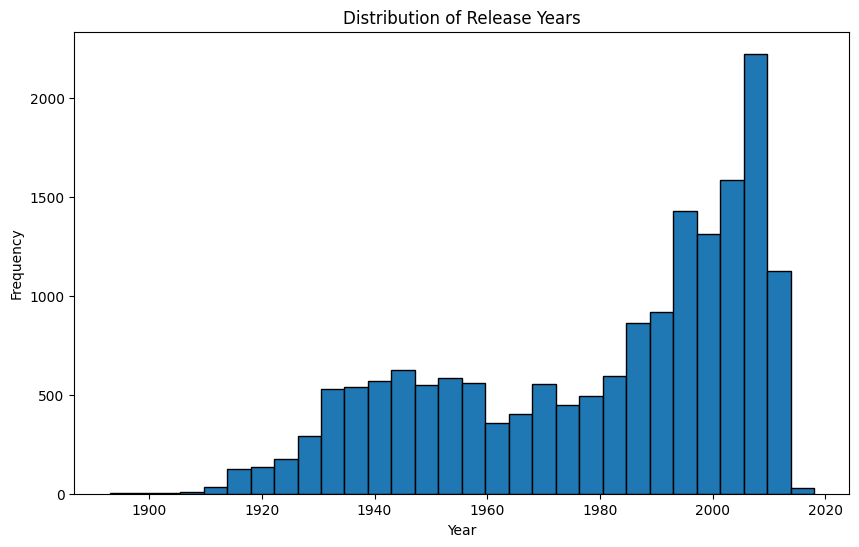

In [29]:
Date = Movie_Data["Release date"].str[:4].astype(int)
plt.figure(figsize=(10, 6))
plt.hist(Date, bins=30, edgecolor='black')
plt.title('Distribution of Release Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

# Looks nice ! no outliers :)

In [50]:
# Save the data 
#Movie_Data.to_csv(clean+"/Movie_Data_clean.tsv", sep="\t")

<h3 style="color: blue;">0.1.4 Human labelled data</h3>  <a id="humanlabeldata"></a>


For your project, we needed to assign to each movie a violence level. We therefore performed a human-labelling steps to create a training/validation set. This data also need to be cleaned.

<b> First step: labelling the Data </b> \
Since labeled data is required for analysis, we manually labeled a subset of the dataset. We divided part of the data among team members and, to ensure the subjectivity of the labeling process, we had some plots labeled multiple times by external participants. Each movie plot was classified based on a categorical scale:
<ul>
    <li><b>-1</b> : Peaceful</li>
    <li><b>0</b> : Mild</li>
    <li><b>1</b> : Violent</li>
</ul>

<b>Data preprocessing steps</b> \
We will apply the following pipeline:

<ul>
    <li>load The data</li>
    <li>Assess the subjectivity of the data</li>
    <li>Make each label unique</li>
    <li>Save the data</li>
</ul>

In [30]:
#load the labelled data
ViolentLabel,ViolentData = data_loader.human_labelled_data("Raw")
display(ViolentLabel)
display(ViolentData.head(3))
# LAST is  boolean to recognize the point we added to help the analysis, more explanation after

,Violence level,Label
0,Peaceful,-1
1,Mild,0
2,Violent,1


,Answer,Date,LAST
Wikipedia movie ID,,,
19286405,0,11.11,0
6714641,1,11.11,0
27573594,1,11.11,0


##### 0.1.4.1 Assess subjectivity and clean the data

Some data have been labelled several times by several people, to assess the subjectivity of the labelling task. \
Let's visualize the data.
Here we will plot only datapoint that have been labelled at least 2 times. 

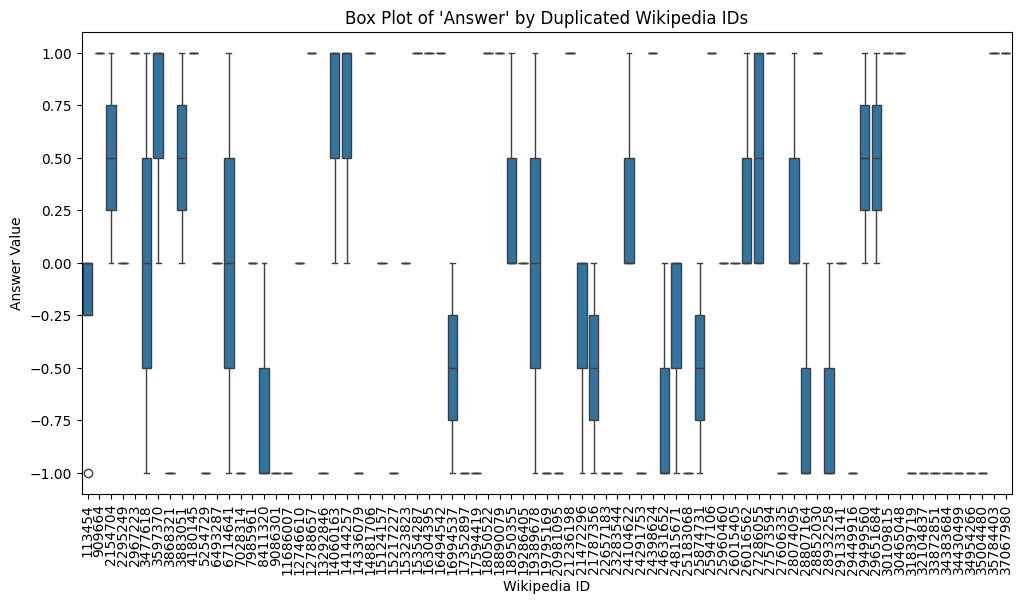

In [31]:
DataBefore = ViolentData[ViolentData["LAST"] == 0]
duplicated_data = DataBefore[DataBefore.index.duplicated(keep=False)]

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=duplicated_data, x="Wikipedia movie ID", y="Answer")

# Add labels and title
plt.title("Box Plot of 'Answer' by Duplicated Wikipedia IDs")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [32]:
print("We have",len(DataBefore.index.unique()),"labelled plots")
print("We have",len(duplicated_data.index.unique()),"duplicated labelling")
print("We have",(duplicated_data.groupby("Wikipedia movie ID")["Answer"].nunique() > 1).sum(),"datapoint with different labels")

We have 146 labelled plots
We have 79 duplicated labelling
We have 25 datapoint with different labels


In [33]:
DataBefore.groupby("Wikipedia movie ID").size().value_counts().sort_index()

1    67
2    40
3    36
4     2
6     1
Name: count, dtype: int64

The task is more difficult than expected !
A majority of duplicated labelling show the same output. However, we have different value for 24 points. Additionnaly, for 3 points we have the 3 answers ! We will take a closer look to this point and to the point with opposite labels.

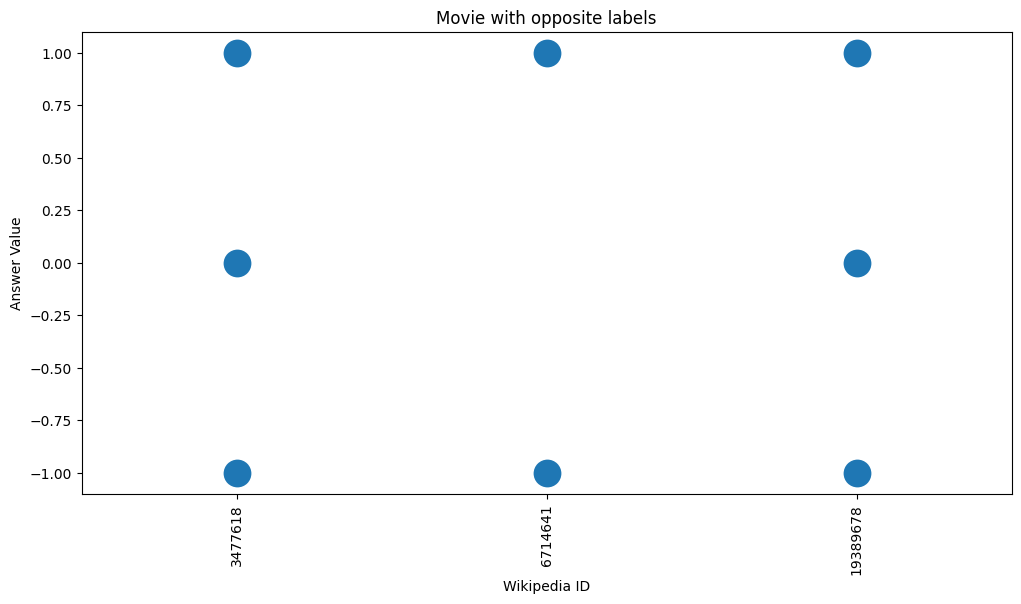

In [34]:
OppositeLabels = duplicated_data.groupby("Wikipedia movie ID").filter( lambda group: set([-1, 1]).issubset(group["Answer"].unique()))

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.swarmplot(data=OppositeLabels, x="Wikipedia movie ID", y="Answer", size=20)

# Add labels and title
plt.title("Movie with opposite labels")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [35]:
for plot in Movie_Data.loc[OppositeLabels.index.unique()]["Plot"] :
    display(plot)
    print("\n\n")

'after serving time for the attempted murder of his first wife, the main character, a doctor, begins plotting to kill his second.'

'a lewd old lady claiming to be mother goose has been put on trial for obscenity, and the evidence being presented is a collection of pornographic animated shorts. little red riding hood, jack of jack and the beanstalk fame, cinderella and snow white are among the most notable participants in what becomes an all out fairy tale orgy.'

'the gang tries to escape their babysitting chores by coercing spanky to mind their baby brothers and sisters while they go swimming. unfortunately, the infants would prefer to run  amok, forcing spanky to take desperate measures.<ref namehttp://movies.nytimes.com/movie/225666/forgotten-babies/overview |title2008-09-19|work=ny times}}'

We can distinguish 3 types of datapoints :

have been labeled multiple times with always the same label : We keep this label.
have been labeled multiple times with different labels but the mean is closer to 1 label (example 3 labels (0,0,1)) : we could keep the label closest to the mean, we will take a deep look and relabel if necessary.
have been labeled multiple times with different labels and the mean is exactly between 2 labels : We will take a closer look and re-label by another person.
After relabelling, here is the result

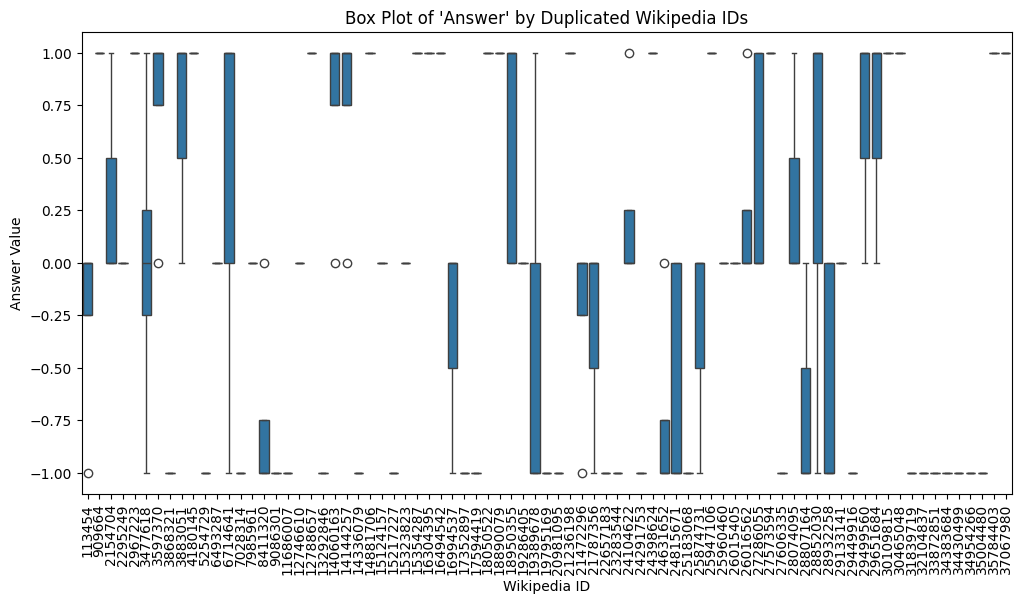

In [36]:
duplicated_data_clean = ViolentData[ViolentData.index.duplicated(keep=False)]

# Plot all duplicates in one figure with side-by-side boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(data=duplicated_data_clean, x="Wikipedia movie ID", y="Answer")

# Add labels and title
plt.title("Box Plot of 'Answer' by Duplicated Wikipedia IDs")
plt.xlabel("Wikipedia ID")
plt.xticks(rotation=90)
plt.ylabel("Answer Value")

plt.show()

In [37]:
ViolentData.groupby("Wikipedia movie ID").size().value_counts().sort_index()

1    67
2    31
3    32
4    11
5     4
7     1
Name: count, dtype: int64

In [38]:
FinalData = ViolentData.groupby("Wikipedia movie ID")["Answer"].median().to_frame()
FinalData.head()

,Answer
Wikipedia movie ID,
113454,0.0
909664,1.0
1028671,0.0
1336564,0.0
1472852,-1.0


In [39]:
FinalData[~FinalData["Answer"].isin([-1, 0, 1])]

,Answer
Wikipedia movie ID,



The labelling step is done ! We save the data.

In [40]:
#data_loader.save_back_to_excel(ViolentLabel, FinalData)

<h2 style="color: blue;">0.2 Real World Violence Dataset </h2> <a id="reallifedata"></a>

To be able to build analysis on real-violence we need additional data. We chose to keep two datasets that complement each other : GVD and NIBRS. The first provides an overview of violent deaths per year from 2004 to 2021, while the latter gives much more granular information. The aim is to pinpoint interesting set of years to dweleve in with NIBRS dataset, while having an overview thanks to GVD one. 

    
⁠ **NIBRS, National Incident-Based Reporting System :** Offers daily-level crime data 
   -Source: https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/downloads
   -Description : Reported crimes to the FBI per state and per year with detailed information such as victims related ones, crime and so on. 
   - NIBRS data offers more precise informations about daily crimes as it provides the precise date of an incident. 
   - Each incident can easily be classified in order to keep only violent crimes.
   - To go further, NIBRS can provide victim's injury, incident circumstances and if weapons were used during the incident.
  
*Data preprocessing step for NIBRS*
We have applied the following step in order to have well-formated and useful data:
<ul>
<li>For each state all the yearly data need to be downloaded and stored with the following protocol: 
  

Name_of_the_state folder\
├── XX-year1\
├── XX-year2\
├── XX-year3\
...
</li>

<li>⁠Iteration on each XX-year folder in order to modify in lowercase all the name and label of each file.</li>
<li>⁠Merging of useful parameters:<ul>
<li>incident_id ⁠: unique identifier of each incident</li>
<li>incident_date ⁠: precise date of the incident</li>
<li>offense_type_id ⁠: type of offense of the incident</li>
<li>Help to get ⁠ offense_name ⁠ (e.g., Assault Offenses, Homicide Offenses)</li>
<li>Help to get ⁠ crime_against ⁠ (e.g., Society, Person)</li>
<li>arrestee_id ⁠: identifier of the arrestee</li>
<li>weapon_id ⁠: identifier of the weapon used (if one was used)</li>
<li>victim_id ⁠: identifier of the victim</li>
<li>injury_id ⁠: identifier of victim injury</li>
<li>circumstances_id ⁠: identifier of circumstances related to the incident</li>
    </ul></li>
<li>Data cleaning:⁠<ul>
  <li> Keep only incidents with violent ⁠ offense_name⁠</li>
  <li> Keep only incidents with ⁠ crime_against ⁠ = Person</li></ul></li>
<li>Save the cleaned dataset</li>
<ul>



You'll find the entire database [here](https://www.dolthub.com/repositories/Liquidata/fbi-nibrs/data/main) to help to visualize the entire data.

The downloaded data comes from the [**FBI Crime Data Explorer**](https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/downloads).


In [ ]:
#import relative script 
import src.data.FBI_cleaning
import src.data.FBI_merging
import src.data.FBI_analysis

from FBI_preprocess_folder import preprocess_files_in_directory
from FBI_merging import process_state_data,merge_offense_types
from FBI_analysis import analyze_incidents_and_missing_values,analyze_offenses
from FBI_cleaning import filter_violent_offenses

ModuleNotFoundError: No module named 'FBI_cleaning'

##### 0.2.1.1 load and merge the data (Alabama, as a first example)

In order to have all reported incidents for a given state, we have the merge multiple datafiles. 

**Preprocessing**

It is needed to do a preprocessing on each state folder in order to have only lowercase in the folder and label name. The function `preprocess_files_in_directory()` directly modify the folder name and labels in each file.

In [2]:
# Define the base directory where Alabama data is stored
state_dir = raw +'/Alabama'

# Run the function to preprocess all files in the Alabama directory
preprocess_files_in_directory(state_dir)

NameError: name 'raw' is not defined

**Merging interesting data**

In [ ]:
# Define the output file
output_file = os.path.join(state_dir, 'Alabama_merged_data.csv')

# Process data for the state and save it
final_data = process_state_data(state_dir, output_file)


In [ ]:
final_data

**Let's visualize the data**

In [ ]:
importlib.reload(FBI_analysis)

# Analyze and visualize the incidents and missing values per column
analyze_incidents_and_missing_values(final_data, 'incident_date', verbose=False)

**Analysis Summary**
From the bar plots, we observe the following:

1. **Data concentration in 1991 and 1992:**
   - The majority of the data is concentrated in the years 1991 and 1992, with very limited data for other years. This may limit the temporal analysis but provides a strong starting point for studying patterns in these two years.
   - Further investigation across other states might help fill in data gaps for a more comprehensive view.
2. **Missing `incident_date` values:**
   - A few `incident_date` values are missing, specifically 14280. Despite these missing dates, the remaining data is largely complete.
3. **Availability of `offense_type_id`:**
    - All offense types are available, which is good for categorizing offenses based on our criteria for violence. This will help us to classify offenses and filter incidents related to violent behavior.
4. **Missing Data for Specific Parameters:**
    - Four key columns (`arrestee_id`, `weapon_id`, `injury_id`, and `circumstances_id`) show a significant number of missing values, as indicated in the NaN count plot.
    - We hope additional data from other states can fill in some of these gaps. However, since offense types are available, we can still proceed with classification based on offenses alone.
5. **Insights on Weapons and Injuries:**
    - The weapon_id and injury_id columns, though missing some values, provide information on the type and severity of violence. While this missing data presents some limitations, the existing offense data could compensate.

So, despite some missing values in specific columns, the precise date of the incident, the available offense data and partial details on weapons and injuries can provide a solid foundation for analyzing violent incidents. We can refine our approach further as more data becomes available from additional states.

In [ ]:
# Define the base directory where Alabama data is stored
base_dir = '../../data/RAW/Alabama'
state_prefix = 'AL'

# Analyze and visualize the offenses
analyze_offenses(final_data, base_dir, state_prefix, verbose=False)

**Analysis of Offense Types**

From the bar plots, we can say:

1. **Unique offense types in `State_merged_data`:**
    - The first plot shows the number of unique offense types present in the `State_merged_data`, in our example Alabama. We observe that a subset of approximately 45 unique offenses is available in the data.
    - This means that the majority of incidents fall into well-defined and recurring offense categories. It will help us to categorize incidents reliably based on these established classifications.
2. **Top 10 Most Frequent Offense Types:**
    - The second plot displays the top 10 most frequently cited offense types in the dataset, along with their occurrence counts. Offenses like *Burglary/Breaking & Entering*, *All Other Larceny*, and *Simple Assault* are the most common.
    - These recurring offenses serve as strong indicators for our analysis, particularly for categorizing incidents as violent or non-violent.
  
In summary, the offenses available in the NIBRS data for Alabama are not only varied but also recurrent, which provides a reliable basis for violent incident classification. The top 10 offenses illustrate the primary incident types and should help us for further analysis focused on identifying patterns of violent behavior.

##### 0.2.1.2 Clean the data (the case of Washington)

After loading and merging the data for one state, we need to clean the data. We will use the case of the state of Washington

In [ ]:
# Load the washington data
WA_data_example = pd.read_csv(raw+"/Washington/Washington_merged_data.csv", index_col=0)
WA_data_example

In order to clean the data, we will use data that gives `offense_type`. To do so, we have to iterate through the years to get all offense types. We save the results in `offense_data`

In [ ]:
importlib.reload(FBI_merging)

offense_data = merge_offense_types(raw +'/Washington', 'WA')

To clean a state data (in our example Washington), we have to keep only violent incidents. As a proof of concept, we will only focus on 2 parameters used in `offense_data`:
-  crime against a `Person`
-  violent categories found in `offense_category_name`

In [ ]:
# Visualize offense_data
offense_data

In [ ]:
# Example of violent categories and targets used in filter_violent_offenses
# violent_categories = [
#         "Assault Offenses", "Homicide Offenses", "Sex Offenses", "Kidnapping/Abduction", "Animal Cruelty"]
#     violent_targets = ["Person"]  # Offenses against a person

# Clean the data by filtering out non-violent offenses
WA_cleaned_data = filter_violent_offenses(WA_data_example, offense_data)

# Save the cleaned data
state_clean_dir = clean
output_file = os.path.join(state_clean_dir, 'Washington_cleaned_data.csv')

WA_cleaned_data.to_csv(output_file, index=False)

In [ ]:
WA_cleaned_data

**Comparison before/after cleaning**

In [ ]:
importlib.reload(FBI_analysis)

# Analyze and visualize the incidents and missing values per column
analyze_incidents_and_missing_values(WA_data_example, 'incident_date', verbose=False)

In [ ]:
# Analyze and visualize the incidents and missing values per column
analyze_incidents_and_missing_values(WA_cleaned_data, 'incident_date', verbose=False)

In [ ]:
# Define the base directory where Alabama data is stored
base_dir = raw +'/Washington'
state_prefix = 'WA'

# Analyze and visualize the offenses
analyze_offenses(WA_cleaned_data, base_dir, state_prefix, verbose=False)

The first plot shows that the majority of incidents fall into well-defined and recurring offense categories. It will help us to categorize incidents reliably based on these established classifications

The second plot shows that the top 10 most reccurent violent offense.


<h1 style="color: blue;">1.  Characterisation of movies violence</h1>
<a id="movieanalysis"></a>




<h2 style="color: blue;">1.1. Violent words</h2>
<a id="violentwords"></a>

Now starts the characterization of our movies. First, we want to look into the plots and count how many violent words appear in the summary. \
Here, two things are worth notice: 
1. The list of words is souced from the web and agumented by us, for more completeness. Therefore, there is some subjectivity on our violence score: it depends on which terms we added. To know more about it see <span style="color:red"> physical_violence_words_justifications.txt </span> & <span style="color:red">psychological_violence_words_justifications</span> in the data/CLEAN/violent_word_list folder.
2. The summaries are not all the same length. Hence, we use the density of violent words in the plots to characterize violence. 

Here we start with the generic list of violent words. Then we will have a list for words related to psychological violence.


<h3 style="color: blue;">1.1.1 Generic violent words</h3> <a id="genericviolentwords"></a>

Here we look into violence in "generic terms". All spheres were included, without distinction between psychological violence, physical harm, etc. 

In [5]:
# Let's have a look at the selected words for our first list (physical violence)
violent_word_list = data_loader.Violent_word_list("Physical_violence")
print(violent_word_list)

NameError: name 'data_loader' is not defined

In [65]:
# We put the list to a Pandas Dataframe
violence_list = pd.DataFrame(violent_word_list)

In [66]:
# We create an excel out of the list, so that if we want to modify it later we don't need to come back inside the code
# violence_list.to_excel(clean+"/violent_word_list/Physical_violence.xlsx", index=False,header=False)

<h3 style="color: blue;">1.2.1 Specific violent words extraction: psychology</h3> <a id="specificviolentwords"></a>

Here we follow the same procedure, but by focusing on psychological violence. We want to see if we can evidence any specific trend, relevant genre, etc. correlated to this specific type of violence. 

In [67]:
# Let's have a look at the selected words for our second list (psychological violence)
psycho_violence_list = data_loader.Violent_word_list("Psychological_violence")
print(psycho_violence_list)

['abandoned', 'abandoning', 'abandonment', 'abuse', 'abused', 'abusing', 'abusive', 'agitate', 'agitated', 'agitating', 'agony', 'alienate', 'alienated', 'alienating', 'amnesia', 'anger', 'angry', 'anguish', 'animalistic', 'antagonise', 'antagonize', 'attack', 'attacked', 'attacking', 'anxious', 'avoid', 'avoided', 'avoiding', 'backhanded', 'belittle', 'belittled', 'belittling', 'betray', 'betrayal', 'betrayed', 'betraying', 'blackmail', 'blackmailed', 'blackmailing', 'blame', 'blamed', 'blame-shifting', 'blaming', 'brainwash', 'brainwashed', 'brainwashing', 'break', 'breaking', 'broken', 'bully', 'bullied', 'bullying', 'catastrophise', 'catastrophize', 'catastrophising', 'catastrophizing', 'chaos', 'condescending', 'condescendent', 'condition', 'conditional', 'control', 'controlled', 'controlling', 'criticism', 'criticise', 'criticize', 'criticised', 'criticized', 'criticising', 'criticizing', 'cruel', 'cruelty', 'damaging', 'deceive', 'deceit', 'deceptive', 'defame', 'demean', 'demea

In [68]:
# We put the list to a Pandas Dataframe
psycho_list = pd.DataFrame(psycho_violence_list)

In [69]:
# We create an excel out of the list, so that if we want to modify it later we don't need to come back inside the code
#psycho_list.to_excel(clean+"/violent_word_list/Psychological_violence.xlsx", index=False,header=False)


<h2 style="color: blue;">1.2.2 Violent words analysis</h2> <a id="violentwordsanalysis"></a>

In [70]:
# We use the WordCounter class to investigate the density of violent words in the summaries

# Now you can import the script like a module
from Word_counter import WordCounter

For Wordcounter see file Word_counter.py. We can either use one list only, with the keywords _Physical_violence_ & _Psychological_violence_, or all lists with keyword _All_. Note that, with this method if non-existing keywords are given as inputs, the 

In [71]:
Word_Counter = WordCounter(data_loader, Movie_Data)

In [72]:
# Let's look at the count of violent words (both )
Count_violent = Word_Counter.violent_word_count("All")

word count for the list : Physical_violence
word count for the list : Psychological_violence
total count
calculate density
done !


In [73]:
# We look at our results
Count_violent

,word_count_Physical_violence,word_count_Psychological_violence,total_count,density word_count_Physical_violence,density word_count_Psychological_violence
Wikipedia movie ID,,,,,
3217,3,3,479,0.006263,0.006263
3333,1,5,858,0.001166,0.005828
3746,3,3,669,0.004484,0.004484
3837,7,3,631,0.011094,0.004754
3947,7,7,930,0.007527,0.007527
...,...,...,...,...,...
36956792,6,2,780,0.007692,0.002564
37067980,0,0,50,0.000000,0.000000
37210334,1,1,259,0.003861,0.003861


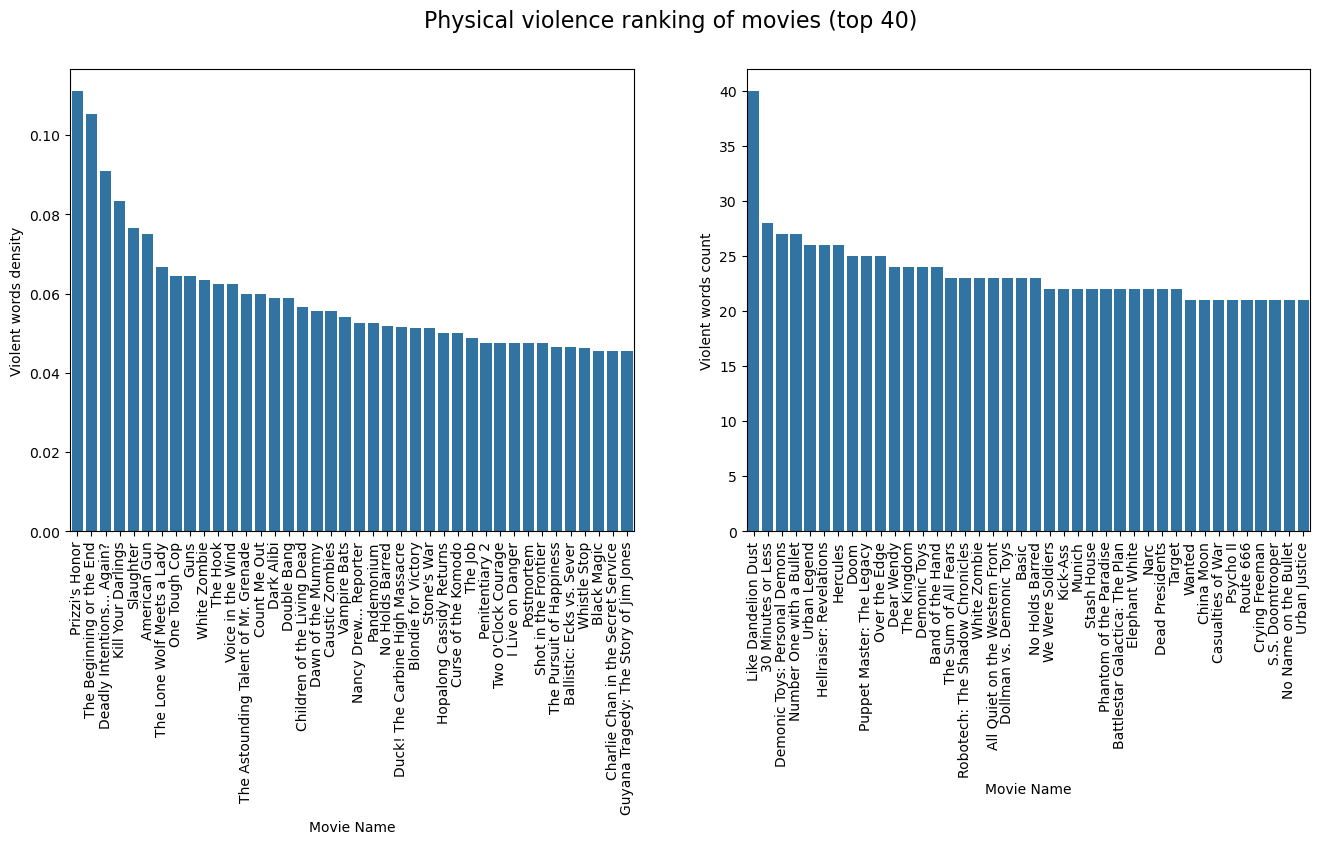

In [74]:
# Let's plot the 40 most violent (physically) movies 

# First we sort the values
Count_violent_sorted_physical = Count_violent.sort_values(by='density word_count_Physical_violence', ascending=False)

# We retreive the movie name from the Movie_Data dataframe
indices_physical_violence = Count_violent_sorted_physical.head(40).index
movie_names = Movie_Data.loc[indices_physical_violence, 'Movie name']
density_physical_violence = Count_violent_sorted_physical.head(40)['density word_count_Physical_violence']

# We do the same but for the words
Count_violent_sorted_physical_by_words = Count_violent.sort_values(by='word_count_Physical_violence', ascending=False)
indices_physical_violence_by_words = Count_violent_sorted_physical_by_words.head(40).index
movie_names_by_words = Movie_Data.loc[indices_physical_violence_by_words, 'Movie name']
physical_violence_by_words = Count_violent_sorted_physical_by_words.head(40)['word_count_Physical_violence']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x=movie_names, y=density_physical_violence, ax=ax1)
ax1.set_xlabel("Movie Name")
ax1.set_ylabel("Violent words density")
ax1.tick_params(axis='x', rotation=90)

sns.barplot(x=movie_names_by_words, y=physical_violence_by_words,  ax=ax2)
ax2.set_xlabel("Movie Name")
ax2.set_ylabel("Violent words count")
ax2.tick_params(axis='x', rotation=90)
fig.suptitle("Physical violence ranking of movies (top 40)", fontsize=16)
plt.show()


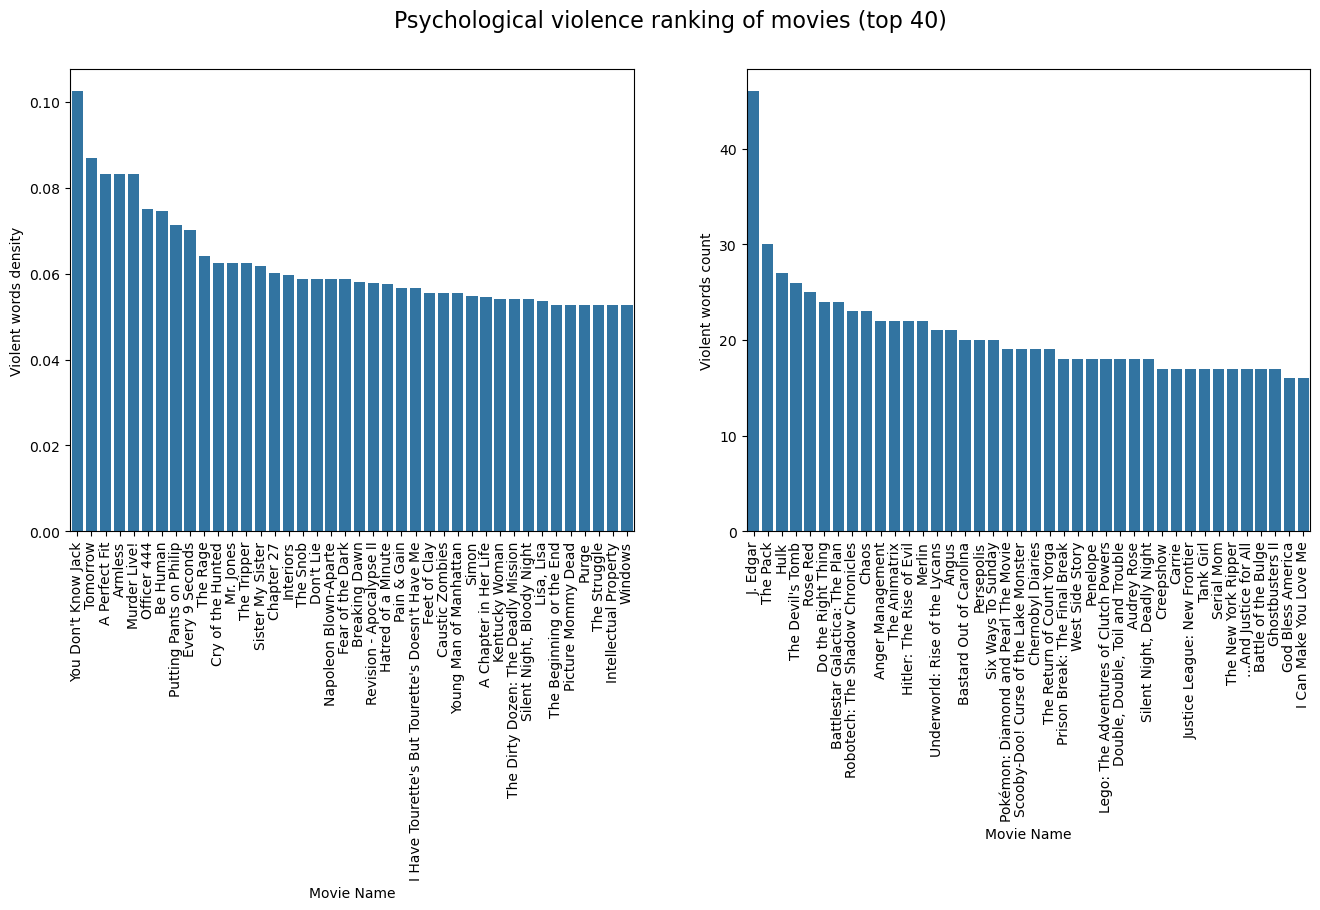

In [75]:
# Let's plot the 40 most violent (psychologically) movies 

# First we sort the values
Count_violent_sorted_psycho = Count_violent.sort_values(by='density word_count_Psychological_violence', ascending=False)

# We retreive the movie name from the Movie_Data dataframe
indices_psycho_violence = Count_violent_sorted_psycho.head(40).index
movie_names = Movie_Data.loc[indices_psycho_violence, 'Movie name']
density_psycho_violence = Count_violent_sorted_psycho.head(40)['density word_count_Psychological_violence']

# We do the same but for the words
Count_violent_sorted_psycho_by_words = Count_violent.sort_values(by='word_count_Psychological_violence', ascending=False)
indices_psycho_violence_by_words = Count_violent_sorted_psycho_by_words.head(40).index
movie_names_by_words = Movie_Data.loc[indices_psycho_violence_by_words, 'Movie name']
psycho_violence_by_words = Count_violent_sorted_psycho_by_words.head(40)['word_count_Psychological_violence']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x=movie_names, y=density_psycho_violence, ax=ax1)
ax1.set_xlabel("Movie Name")
ax1.set_ylabel("Violent words density")
ax1.tick_params(axis='x', rotation=90)

sns.barplot(x=movie_names_by_words, y=psycho_violence_by_words,  ax=ax2)
ax2.set_xlabel("Movie Name")
ax2.set_ylabel("Violent words count")
ax2.tick_params(axis='x', rotation=90)
fig.suptitle("Psychological violence ranking of movies (top 40)", fontsize=16)
plt.show()


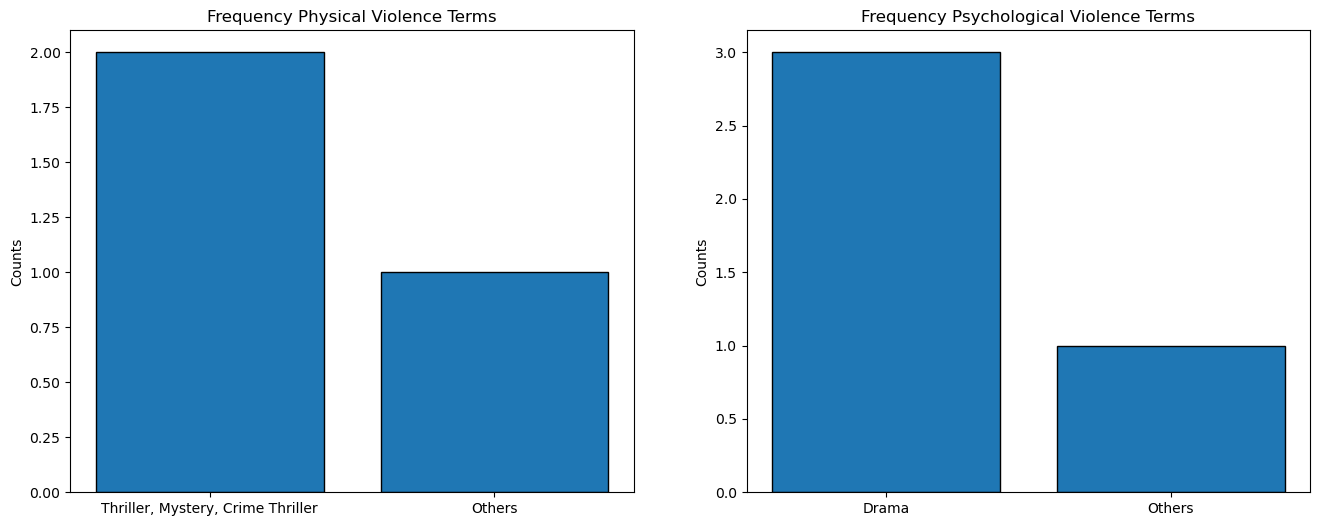

In [76]:
# We retreive the genre for most physically & psychologically violent movies

# Count genres appearances
movie_genres_physical = Movie_Data.loc[indices_physical_violence, 'Genres'].value_counts()
movie_genres_psycho = Movie_Data.loc[indices_psycho_violence, 'Genres'].value_counts()

# Group by the counts
genres_physical_more_once = movie_genres_physical[movie_genres_physical > 1]
genres_physical_once = movie_genres_physical[movie_genres_physical == 1]

genres_psycho_more_once = movie_genres_psycho[movie_genres_psycho > 1]
genres_psycho_once = movie_genres_psycho[movie_genres_psycho == 1]

# Prepare for plotting
labels_physical = list(genres_physical_more_once.index) + ["Others"]
heights_physical = list(genres_physical_more_once.values) + [1]

labels_psycho = list(genres_psycho_more_once.index) + ["Others"]
heights_psycho = list(genres_psycho_more_once.values) + [1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.bar(labels_physical, heights_physical, edgecolor='black')
ax1.set_ylabel('Counts')
ax1.set_title('Frequency Physical Violence Terms')

ax2.bar(labels_psycho, heights_psycho, edgecolor='black')
ax2.set_ylabel('Counts')
ax2.set_title('Frequency Psychological Violence Terms')
plt.show()


<h2 style="color: blue;">1.4 Sentiment Analysis</h2><a id="sentiment"></a>


In this section, we will apply the DistillBERT sentiment analysis model to the clean dataset and save the result.

In [78]:
## Import the script like a module
import DistillBERT_emotion

/home/jen/.local/share/mamba/envs/ADA_project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ModuleNotFoundError: No module named 'torch'

In [ ]:
# Load raw data
data_loader = DataLoader(raw,clean)

# Are we working on the test set
Test_set_data = True
# Run everything again ? 
Run = False

if Test_set_data :
    MovieData = data_loader.plot_data()
    MovieName = data_loader.movie_data()["Movie name"]
    ViolentLabel, ViolentData = data_loader.human_labelled_data()
    MovieData = MovieData.loc[ViolentData.index.unique()]
    MovieData = pd.merge(MovieData,MovieName, left_index=True, right_index=True,how="inner")
else :
    MovieData = data_loader.clean_movie_data()

In [45]:
if Run :
    # Lists to accumulate rows for efficiency
    sentiment_data = []
    
    detector = DistillBERT_emotion.ViolenceDetector()
    i = 0
    for index,row in MovieData.iterrows():
        if i%1000 ==0:
            print(i)
        result = detector.analyze_violence(row["Plot"])
    
        sentiment_data.append({
                "Wikipedia movie ID": index,
                "name" : row["Movie name"],
                "sadness": result[0],
                "joy": result[1],
                "love": result[2],
                "anger": result[3],
                "fear": result[4],
                "surprise": result[5]
            })
        i += 1
    
    Sentiment = pd.DataFrame(sentiment_data)

In [46]:
if Run : 
    # Save the result
    if Test_set_data : 
        Sentiment.to_csv(clean + "/sentiment_test.csv") 
    else : 
        Sentiment.to_csv(clean + "/sentiment.csv") 
else :
    SentimentData, SentimentDataTest = data_loader.load_sentiment()
    if Test_set_data :
        Sentiment = SentimentDataTest
    else :
        Sentiment = SentimentData

In [ ]:
Sentiment = Sentiment.set_index("Wikipedia movie ID")
Sentiment.head()

In [ ]:
# Sentiment analysis using DistillBERT_emotion

X = 30
emotions = ["sadness",
            "joy",
            "love",
            "anger",
            "fear",
            "surprise"]

# Create a figure with subplots (1x3 grid)
fig, axes = plt.subplots(2, 3, figsize=(16,12))

# Set a title for the entire figure
fig.suptitle('Top Emotion Scores for Movies', fontsize=16)

for i in range(0,len(emotions)):
    
    # Plot for Sadness with vertical x labels
    sns.barplot(x='name', y=emotions[i], data=Sentiment.sort_values(emotions[i],ascending=False).iloc[0:min(X,Sentiment.shape[0])],ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Top {emotions[i].capitalize()} Scores')
    axes[i//3, i%3].set_xlabel('Movie ID')
    axes[i//3, i%3].set_ylabel(f'{emotions[i].capitalize()} Score')

    axes[i//3, i%3].set_xticks(range(min(X,Sentiment.shape[0])))  # Ensure ticks are set
    axes[i//3, i%3].set_xticklabels(axes[i//3, i%3].get_xticklabels(), rotation=90)


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.show()

<h1 style="color: blue;">2. Movies classification</h1><a id="movieclass"></a>


Now that we have a better idea of what our movies look like from the analysis of their plot, we would like to classify them into non-violent, mild and violent. \
To do that, we will use surely the results previously obtained from the plots. However we ask ourselves: how do we combine the results from the psychological violence and the physical violence terms? \
To answer this question we decided to include a sentiment analysis of our plots, and to use the latter together with the results obtained from the plots to create a regression model. By doing this we can infer the weights of each feature for our model. Hence, we humanly-labelled 100 summaries and used those as training set. 


<h2 style="color: blue;">2.1 Regression mode
</h2> <a id="regression"></a>

<b> The Model </b> \
For simplicity, we chose to perform a logistic regression using several selected features.


<b> The features </b> \
The selected feature set includes:
<ul>
    <li><b>Word Count Features</b>
        <ul> 
            <li>Count of physically violent words</li> 
            <li>Count of psychologically violent words</li> 
            <li>Density of physically violent words</li> 
            <li>Density of psychologically violent words</li>
        </ul>
    </li>
    <li><b>Sentimental Analysis Features</b>
       <ul>
           <li>Sadness</li>
           <li>Joy</li>
           <li>Love</li>
           <li>Anger</li>
           <li>Surprise</li>
       </ul>
    </li>
</ul>



<b> The Dataset </b> 
<ul>
    <li><b>Training and Testing Data</b> <br/> Given the limited number of labeled plots available, we will use most of the labeled items for the training set. We will keep 20% plots as the testing set to evaluate the model (alternatively, we may use the entire dataset and assess labeling quality across the final labeled set) </li>
    <li><b>Final Dataset</b>  <br/> We will apply the model to label the entire dataset and review the quality of the labels.</li>
</ul>

In [ ]:
# Load the data
data_loader = DataLoader(raw,clean)
MovieData,DataTest = data_loader.data_for_violent_model()
MovieData.head()

In [ ]:
# Load the labelled data
ViolentLabel,ViolentData = data_loader.human_labelled_data()
display(ViolentLabel)
display(ViolentData.head())

In [59]:
FinalSet = MovieData.loc[MovieData.index.difference(ViolentData.index)]

In [ ]:
TestSet = pd.merge(DataTest,ViolentData["Answer"],left_index=True,right_index=True,how = "inner")
TestSet = TestSet.drop(["Unnamed: 0"],axis = 1)
TestSet.head()

In [ ]:
fraction = 0.2

# Split the data between train and validation
TrainingSet,ValidationSet = train_test_split(TestSet, test_size=fraction, random_state=21)

print(TrainingSet.shape[0])
print(ValidationSet.shape[0])

#### Model

In [ ]:
#model = Ridge(alpha=6)
#model.fit(TestSet.drop(["Answer","name"], axis=1), TestSet["Answer"])

#model = LinearRegression()  # create the model
#model.fit(TestSet.drop(["Answer","name"], axis=1), TestSet["Answer"])  

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(TrainingSet.drop(["Answer","name"], axis=1), TrainingSet["Answer"])

In [ ]:
print("coefficient",model.coef_)
print("intercept",model.intercept_)
model.score(TrainingSet.drop(["Answer","name"], axis=1), TrainingSet["Answer"])

In [64]:
Compare = pd.DataFrame(model.predict(ValidationSet.drop(["Answer","name"], axis=1)),index=ValidationSet.index,columns=["Prediction"])
Compare["Label"] = ValidationSet["Answer"]

In [ ]:
accuracy = metrics.accuracy_score(Compare["Label"],Compare["Prediction"])
print("accuracy",accuracy*100)

m1 = abs(Compare["Label"]-Compare["Prediction"]).mean()
print("abs distance",m1)

#penalize more if opposite result 
m2 = np.power(Compare["Label"]-Compare["Prediction"], 2).mean()
print("pow distance",m2)

print("Correct label",(Compare["Label"]==Compare["Prediction"]).sum())
print("incorrect but close",(abs(Compare["Label"]-Compare["Prediction"])==1).sum())
print("opposite",(abs(Compare["Label"]-Compare["Prediction"])==2).sum())

Our model is not satisfying yet: the accuracy is only 33% and we have too many incorrect but close labels. This is why we decide to turn to LLM models, to see if we obtain better classification for movies’ violence.


<h2 style="color: blue;">2.2 LLM classification: mutliclass (non-violent, mid-violent, violent)</h2>
<a id="multiclass"></a>


We will try to label the data using a LLM, namely GPT4mini from OpenAI . \
We will use the training set from above as the testing set, and keep 20% as a validation set. 

<b> The Model </b>

We will use the GPT-4o-mini model \
https://platform.openai.com/docs/overview \
https://platform.openai.com/docs/models#gpt-4o-mini

<b> References </b>

https://platform.openai.com/docs/guides/prompt-engineering \
https://medium.com/discovery-at-nesta/how-to-use-gpt-4-and-openais-functions-for-text-classification-ad0957be9b25 \



<h3 style="color: blue;">2.2.1 Data preparation for LLM</h3><a id="
dataprepllm"></a>


In [ ]:
#load the data
CleanData = data_loader.clean_movie_data()
PlotData = data_loader.plot_data()

In [ ]:
#load the labelled data
ViolentLabel,ViolentData = data_loader.human_labelled_data()
display(ViolentLabel.drop(["Unnamed: 0"],axis = 1))
display(ViolentData.head())

In [ ]:
TestSet = pd.merge(ViolentData,PlotData, left_index=True,right_index=True, how = "inner")
print("Number of test point :",TestSet.shape[0])
TestSet.head()

In [ ]:
TestSet.iloc[0]["Plot"]

In [ ]:
fraction = 0.2

# Split the data between train and validation
TrainingSet,ValidationSet = train_test_split(TestSet, test_size=fraction, random_state=21)

print(TrainingSet.shape[0])
print(ValidationSet.shape[0])

In [ ]:
TrainingSet.head()

<h3 style="color: blue;">2.2.2 Choice of LLM-GPT-4-mini</h3><a id="llmgpt4mini"></a>


In [74]:
# Now import the Classifier class
from OpenIA_utility import GPT4mini_ViolenceClassifier

<h3 style="color: blue;">2.2.3 Prompt engineering</h3><a id="prompt"></a>

We developed a prompt for the classification task. \
The prompt contains a clear violence scale, where each label (Peaceful,Mild,Violent) in explained, and a clear instruction.

To help the model to perform, we add examples.

In [75]:
#init our classifier
Classifier = GPT4mini_ViolenceClassifier()

In [ ]:
print(Classifier.Content)

In [ ]:
print(Classifier.Example)

To ensure the model return the result in the good format, we developed a function.

The final function is :

```ruby
        self.function = {
           "name": "Assign_violence_level",
           "description": "Predict the level of violence of a list of movie plots",
           "parameters": {
               "type": "object",
               "properties": {
                   "prediction": {
                       "type": "array",
                       "items": {
                           "type": "string",
                           "enum": [
                               "Peaceful",
                               "Mild",
                               "Violent"
                           ]
                       },
                       "description": "The list of violence levels for each movie plot, in the same order as the plots were provided."
                   }
               },
               "required": [
                   "prediction"
               ]
           }
        }

```

The model have to return a array of prediction, one for each plot.


<h3 style="color: blue;"> 2.2.4 Verify the number of tokens</h3><a id="tokens"></a>


The model have a maximum number of input tokens ! For our model, the limit is 128000 tokens. For cod efficiency (and money), we would like to avoid having to loop on each plot and recalling the prompt every time. We will look at the number of token to see how many plots we can put at the time. 

We implemented a function that tokenize a text in the same way as the model and return the number of token and the pricing.

In [ ]:
# Count for the prompt (and example)
TotalPromt = Classifier.Prompt_size
print("For the prompt we have",TotalPromt,"tokens, pricing :",TotalPromt*Classifier.pricing)

# Count for the test set
TotalTest = TestSet["Plot"].apply(Classifier.count_tokens).sum()
print("For the test dataset we have",TotalTest+TotalPromt,"tokens, pricing :",TotalTest*Classifier.pricing,"batch",int(TotalTest/(Classifier.max_input-TotalPromt)+1))

# Count for the whole dataset
TotalData = CleanData["Plot"].apply(Classifier.count_tokens).sum()
batch = int(TotalData/(Classifier.max_input-TotalPromt))+1
print("For the whole dataset we have",TotalData,"tokens, pricing :",(TotalData+batch*TotalPromt)*Classifier.pricing,"batch",batch)

Will need to split the data into batchs.


<h3 style="color: blue;">2.2.5 Batch creation</h3><a id="batch"></a>

As we send multiple plot at the time, we need to format them together in a way the model can understand. Here an example :

In [ ]:
TrainingSet.iloc[0]["Plot"]

In [ ]:
#first parameter is the number of the plot, second is the text
Classifier.format_plot(0,TrainingSet.iloc[0]["Plot"])

Batch yes but how to create them ? We need each batch size to be smaller than the model's limit. We implemented a function that combine the prompt and the formatted plot, and add them until it reach the limit. The function return the ID of the first plot of each batch.

In [ ]:
#for the test set (no batch needed)
Classifier.batch_plots(TestSet)

#for the dataset !
#clean_batch = Classifier.batch_plots(CleanData)


<h3 style="color: blue;">2.2.6 LLM classification assesment</h3><a id="llmclass"></a>
Here we go ! Now we will call the model on the test set and compare the result with the human labelled data. Note that we don't have to train the data, but we still split the test data between train and validation. This is because we went to have a set of labelled data to compare the result with during the prompt fine-tuning and all the test of the model. We still want to have a dataset the model have never seen to test at the end with the final model. If the result is good enough, we will label all the dataset.

In [82]:
#just a firewall boolean to avoid running the model by accident
Run_test = False

Here is the format of the final call of the model

```ruby
    completion = self.client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": self.Content},
            {"role": "user","content": Text},
            {"role": "assistant", "content": self.Example}
        ],
        functions=[self.function],
        function_call={"name": "Assign_violence_level"},
    )
```

We format the batch

In [ ]:
Classifier.format_batch(TrainingSet[0:3])

We will also make smaller batch to improve the predictions.

In [ ]:
prediction = []
BatchSize = 10

if Run_test :
    for i in range(0,int(TrainingSet.shape[0]/BatchSize)+1) :
        thisBatch = Classifier.format_batch(TrainingSet[i*BatchSize:min((i+1)*BatchSize,TrainingSet.shape[0])])
        pred = Classifier.Call_API(thisBatch)
        #print("pred",len(pred))
        prediction = prediction + pred
print("finish!")

In [ ]:
print(prediction)

In [ ]:
Compare = pd.DataFrame(prediction,index=TrainingSet.index, columns=["Result"])

def to_level(data) :
    match data:
        case 'Peaceful':
            return -1.0
        case 'Mild':
            return 0.0
        case 'Violent':
            return 1.0
        case _:
            raise Exception("wait is that ?",data)

Compare["Prediction"] = Compare["Result"].apply(to_level)

Compare["Label"] = TrainingSet["Answer"]
Compare.head()

In [22]:
name = "model_1"
Compare.to_csv(clean+"/classification_result/"+name+".csv")

In [ ]:
accuracy = metrics.accuracy_score(Compare["Label"],Compare["Prediction"])
print("accuracy",accuracy*100)

m1 = abs(Compare["Label"]-Compare["Prediction"]).mean()
print("abs distance",m1)

#penalize more if opposite result 
m2 = np.power(Compare["Label"]-Compare["Prediction"], 2).mean()
print("pow distance",m2)

print("Correct label",(Compare["Label"]==Compare["Prediction"]).sum())
print("incorrect but close",(abs(Compare["Label"]-Compare["Prediction"])==1).sum())
print("opposite",(abs(Compare["Label"]-Compare["Prediction"])==2).sum())

In [ ]:
Compare[(abs(Compare["Label"]-Compare["Prediction"])==1)].head()

In [ ]:
Compare[(abs(Compare["Label"]-Compare["Prediction"])==2)]

<b>Testing history :</b>
- <ins>first model</ins> 0.5% accuracy. It is not totally wrong but is usually close but not perfect. This could also be due to error during labelling. As we discussed, the notion of violence is complex. We should take this into account while labelling. We will try to improve the model accuracy by giving him typical *example*. Another problem is that with too much movie, the model forget some labels. we will return a *dictionary* instead of a list to associate the plot number to the returning class and ultimately reduce the *batch size*.
- <ins>Add example to the prompt</ins> the result get a little better. however still a lot of incorrect but close response. Tend to consider more violent than expected. Adapt the class label.
- <ins>Clearer definitions and smaller batch</ins> accuracy arroud 65%, likely to overestimate violence.


<h3 style="color: blue;">2.2.7 Application on whole movie data</h3><a id="whole"></a>

<h3 style="color: blue;">2.3 LLM classification : binary (non-violent, violent)</h3><a id="binary"></a>

## Project Milestone 3 findings

<h1 style="color: blue;">3. Characterisation of classified violent </h1> <a id="characterisationvalidation"></a>


<h3 style="color: blue;">3.1 Plot categorisation using Empath</h3><a id="empath"></a>

Now that we have our classification from the LLM, we decide to cross-validate it, using the Empath module. The rationale behind this is that while we expect the LLM to do a good job, we cannot be sure without further investigation. Since Empath gives us the categories most present in a text, we decide to analyse the summaries of violent and non-violent movies separately, to make sure that the categories that make up the summaries are indeed not the same and especially, that cathegories appearing in each group reflect the presence (or absence) of violence in the texts.

#### 0.2.0 Preliminary considerations and statistics across all movies

First, we fetch our clean movie dataframe and use it to construct two results matrices that will help us to study which are the categories appearing most across all movies.

In [ ]:
"""
    We fetch our Movie_Data CLEAN version from PM2 and create a two dataframes where:
    - each row is a Movie 
    - each column is an empath category 
    
    We save two versions of this analysis: one with normalization and one without. 
"""

from src.data.empath_dataframes import analyze_empath_features

Movie_Data = pd.read_csv('data/CLEAN/Movie_Data_clean.tsv', sep="\t")

empath_df_norm, empath_df_non_norm = analyze_empath_features(Movie_Data, "Plot", "Wikipedia movie ID", "Movie name", "data/CLEAN")
empath_df_non_norm

In [ ]:
# Let's have a quick glimpse at all categories appearing in the dataset
sorted_categories = empath_df_non_norm.drop(columns=["Movie name"]).sum(axis=0).sort_values(ascending=False)

plt.figure(figsize=(24, 16))
plt.bar(sorted_categories.index, sorted_categories.values, color="skyblue", edgecolor="black")
plt.title("Empath Categories Summed Over All Movies", fontsize=20)
plt.xlabel("Categories", fontsize=14)
plt.ylabel("Total Score", fontsize=14)
plt.xticks(rotation=90, ha="right", fontsize=12)
plt.tight_layout()


In [ ]:
# What are the top categories (the ones appearing most across all movies)?
top_categories_list = list(sorted_categories.head(10).index)
cats = "The categories appearing most, in order, are: " + ", ".join(top_categories_list) + "."
print(cats)

In [ ]:
# Get the top categories and their scores to plot
plt.figure(figsize=(10, 6))
sorted_categories.head(10).plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Top 10 Empath Categories by Aggregate Score", fontsize=16)
plt.ylabel("Aggregate Score", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()

In [ ]:
# Which movies have the highest score when it comes to death (category)?

# Get the top deadly movies and their "death" scores
top_deadly_movies = empath_df_non_norm["death"].sort_values(ascending=False).head(10)

# Get corresponding movie names for the x-axis
movie_names = empath_df_non_norm.loc[top_deadly_movies.index, "Movie name"]

plt.figure(figsize=(12, 6))
plt.bar(movie_names, top_deadly_movies, color="red", edgecolor="black")
plt.title("Top 10 Most Deadly Movies by 'Death' Score", fontsize=16)
plt.ylabel("'Death' Score", fontsize=12)
plt.xlabel("Movie Name", fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.show()

As last preliminary analysis, we try PCA, to see if we can already see some clusterings of violent VS non-violent movies. Then, we will delve into the LLM classified movies. 

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(empath_df_non_norm.drop(columns=["Movie name"]))

pca = PCA(n_components=10)
principal_components = pca.fit_transform(empath_df_non_norm.drop(columns=["Movie name"]))

pca_df = pd.DataFrame(data=principal_components, columns=["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6", "PCA7", "PCA8", "PCA9", "PCA10"])

pca_df.index = Movie_Data["Wikipedia movie ID"] 
pca_df["Dominant_category"] = empath_df_non_norm[sorted_categories.head(10).index].idxmax(axis=1)
#display(pca_df)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Component:", explained_variance)

sns.scatterplot(pca_df, x="PCA1", y="PCA2", hue="Dominant_category")

# We export to try to do this in flourish too
#pca_df.to_csv("data/CLEAN/PCA_flourish.tsv", sep="\t")

We see some clustering! Movies dominated by the categories kill, negative_emotion and crime are concentrated at the top of the plot. At the bottom, we find movies that are rather dominated by categories such as: family, children and party. \
Also, the variance explained by the first two columns is good: 0.34 and 0.1 respectively.

In [ ]:
# A close up: let's see if with less movies we still se the same clusterings
sns.scatterplot(pca_df[:500], x="PCA1", y="PCA2", hue="Dominant_category")

<h3 style="color: blue;">3.2 Sentimental analysis</h3><a id="sentiment"></a>

<h3 style="color: blue;">3.2.1 Validation of mutliclass classification</h3><a id="validationmutliclass"></a>

In [ ]:
# Load the dataframe
LLM_results_df = pd.read_csv('data/CLEAN/classification_result/LLM_result.csv')
LLM_results_df.index = LLM_results_df["Wikipedia movie ID"]
LLM_results_df.drop(columns=["Wikipedia movie ID"], inplace=True)
LLM_results_df

In [ ]:
# So, which are the violent movies?
LLM_results_df_violent = LLM_results_df[LLM_results_df["Prediction"] == 1.0]
LLM_results_df_violent

Let's investigate: do the categories appearing most for each movie group make sense with the groups themselves?

In [ ]:
# First: we merge the categories and the LLM predictions
merged_cat_pred = empath_df_non_norm.merge(LLM_results_df, how='left', on='Wikipedia movie ID')
merged_cat_pred


In [ ]:
# Filter: we only keep violent movies
violent = merged_cat_pred[merged_cat_pred['Prediction'] == 1.0]

# Identify: the top 10 categories
category_columns = [col for col in merged_cat_pred.columns if col not in ['Wikipedia movie ID', 'Result', 'Prediction', 'Movie name']]
category_sums_violent = violent[category_columns].sum(axis=0)
top_categories_violent = category_sums_violent.sort_values(ascending=False).head(10).index

# Let's read them out
top_categories_violent_list = list(top_categories_violent)
cats = "The categories appearing most in violent movies are, in order: " + ", ".join(top_categories_violent_list) + "."
print(cats)

In [ ]:
# Filter: we only keep non-violent movies
non_violent = merged_cat_pred[merged_cat_pred['Prediction'] == -1.0]

# Identify: the top 10 categories
category_sums_nv = non_violent[category_columns].sum(axis=0)
top_categories_nv = category_sums_nv.sort_values(ascending=False).head(10).index

# Let's read them out
top_categories_nv_list = list(top_categories_nv)
cats_nv = "The categories appearing most in non-violent movies are, in order: " + ", ".join(top_categories_nv_list) + "."
print(cats_nv)

In [ ]:
# Choose the same 10 random movies
random_rows_movies = violent.sample(10, random_state=50)

# Normalize the scores for violent movies
all_categories_normalized_violent = random_rows_movies[category_columns].div(random_rows_movies[category_columns].sum(axis=1), axis=0)
top_categories_normalized_violent = all_categories_normalized_violent[top_categories_violent]
top_categories_normalized_violent.index = random_rows_movies['Movie name']

# Normalize the scores for top_categories_nv for the same movies
all_categories_normalized_nv = random_rows_movies[category_columns].div(random_rows_movies[category_columns].sum(axis=1), axis=0)
top_categories_normalized_nv = all_categories_normalized_nv[top_categories_nv]
top_categories_normalized_nv.index = random_rows_movies['Movie name']

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot the top categories for violent movies
top_categories_normalized_violent.plot(kind="bar", stacked=True, colormap="gist_heat", ax=axes[0], legend=True)
axes[0].set_title("Category Contributions for Violent Movies", fontsize=16)
axes[0].set_xlabel("Movie Name", fontsize=14)
axes[0].set_ylabel("Categories", fontsize=14)
axes[0].tick_params(axis="x", rotation=90)

# Plot the top categories for nv movies
top_categories_normalized_nv.plot(kind="bar", stacked=True, colormap="viridis", ax=axes[1], legend=True)
axes[1].set_title("Category Contributions for NV Movies", fontsize=16)
axes[1].set_xlabel("Movie Name", fontsize=14)
axes[1].set_ylabel("Categories", fontsize=14)
axes[1].tick_params(axis="x", rotation=90)

fig.tight_layout()
plt.show()

In [ ]:
# Choose the same 10 random movies
random_rows_nv = non_violent.sample(10, random_state=50)

# Normalize the scores for top_categories_violent
all_categories_normalized_v = random_rows_nv[category_columns].div(random_rows_nv[category_columns].sum(axis=1), axis=0)
top_categories_normalized_v = all_categories_normalized_v[top_categories_violent]
top_categories_normalized_v.index = random_rows_nv['Movie name']

# Normalize the scores for top_categories_nv for the same movies
all_categories_normalized_nv = random_rows_nv[category_columns].div(random_rows_nv[category_columns].sum(axis=1), axis=0)
top_categories_normalized_nv = all_categories_normalized_nv[top_categories_nv]
top_categories_normalized_nv.index = random_rows_nv['Movie name']

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot the top categories for violent movies
top_categories_normalized_v.plot(kind="bar", stacked=True, colormap="gist_heat", ax=axes[0], legend=True)
axes[0].set_title("Category Contributions for Violent Movies", fontsize=16)
axes[0].set_xlabel("Movie Name", fontsize=14)
axes[0].set_ylabel("Categories", fontsize=14)
axes[0].tick_params(axis="x", rotation=90)

# Plot the top categories for nv movies
top_categories_normalized_nv.plot(kind="bar", stacked=True, colormap="viridis", ax=axes[1], legend=True)
axes[1].set_title("Category Contributions for NV Movies", fontsize=16)
axes[1].set_xlabel("Movie Name", fontsize=14)
axes[1].set_ylabel("Categories", fontsize=14)
axes[1].tick_params(axis="x", rotation=90)

fig.tight_layout()
plt.show()

<h3 style="color: blue;">3.2.2 Validation of binary classification</h3><a id="validationbinary"></a>

Why did we decide to change the LLM classification? \
We figured out that for the ARDL model, it would be much better to have a binary classification. Hence, we want to check here that this classification is as good as the previous one and that we can use it safely in the next parts of our analysis. 

In [ ]:
LLM_binary_df = pd.read_csv('data/CLEAN/classification_result/LLM_result_binary.csv')
LLM_binary_df.index = LLM_binary_df["Wikipedia movie ID"]
LLM_binary_df.drop(columns=["Wikipedia movie ID"], inplace=True)
LLM_binary_df

In [ ]:
# Again, merge the categories and the predictions
merged_cat_pred_2= empath_df_non_norm.merge(LLM_binary_df, how='left', on='Wikipedia movie ID')
merged_cat_pred_2

In [ ]:
# Filter: we only keep violent movies
violent = merged_cat_pred_2[merged_cat_pred_2['Prediction'] == 1.0]

# Identify: the top 10 categories
category_columns = [col for col in merged_cat_pred.columns if col not in ['Wikipedia movie ID', 'Result', 'Prediction', 'Movie name']]
category_sums_violent = violent[category_columns].sum(axis=0)
top_categories_violent = category_sums_violent.sort_values(ascending=False).head(10).index

# Let's read them out
top_categories_violent_list = list(top_categories_violent)
cats = "The categories appearing most in violent movies are, in order: " + ", ".join(top_categories_violent_list) + "."
print(cats)

In [ ]:
# Filter: we only keep non-violent movies
non_violent = merged_cat_pred_2[merged_cat_pred_2['Prediction'] == -1.0]

# Identify: the top 10 categories
category_sums_nv = non_violent[category_columns].sum(axis=0)
top_categories_nv = category_sums_nv.sort_values(ascending=False).head(10).index

# Let's read them out
top_categories_nv_list = list(top_categories_nv)
cats_nv = "The categories appearing most in non-violent movies are, in order: " + ", ".join(top_categories_nv_list) + "."
print(cats_nv)

In [ ]:
# Choose the same 10 random movies
random_rows_movies = violent.sample(10, random_state=50)

# Normalize the scores for violent movies
all_categories_normalized_violent = random_rows_movies[category_columns].div(random_rows_movies[category_columns].sum(axis=1), axis=0)
top_categories_normalized_violent = all_categories_normalized_violent[top_categories_violent]
top_categories_normalized_violent.index = random_rows_movies['Movie name']

# Normalize the scores for top_categories_nv for the same movies
all_categories_normalized_nv = random_rows_movies[category_columns].div(random_rows_movies[category_columns].sum(axis=1), axis=0)
top_categories_normalized_nv = all_categories_normalized_nv[top_categories_nv]
top_categories_normalized_nv.index = random_rows_movies['Movie name']

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot the top categories for violent movies
top_categories_normalized_violent.plot(kind="bar", stacked=True, colormap="gist_heat", ax=axes[0], legend=True)
axes[0].set_title("Category Contributions for Violent Movies", fontsize=16)
axes[0].set_xlabel("Movie Name", fontsize=14)
axes[0].set_ylabel("Categories", fontsize=14)
axes[0].tick_params(axis="x", rotation=90)

# Plot the top categories for nv movies
top_categories_normalized_nv.plot(kind="bar", stacked=True, colormap="viridis", ax=axes[1], legend=True)
axes[1].set_title("Category Contributions for NV Movies", fontsize=16)
axes[1].set_xlabel("Movie Name", fontsize=14)
axes[1].set_ylabel("Categories", fontsize=14)
axes[1].tick_params(axis="x", rotation=90)

fig.tight_layout()
plt.show()

We can see above, the movies are dominated by the violent categories, rather than by the non-violent ones. 

In [ ]:
# Choose the same 10 random movies
random_rows_nv = non_violent.sample(10, random_state=50)

# Normalize the scores for top_categories_violent
all_categories_normalized_v = random_rows_nv[category_columns].div(random_rows_nv[category_columns].sum(axis=1), axis=0)
top_categories_normalized_v = all_categories_normalized_v[top_categories_violent]
top_categories_normalized_v.index = random_rows_nv['Movie name']

# Normalize the scores for top_categories_nv for the same movies
all_categories_normalized_nv = random_rows_nv[category_columns].div(random_rows_nv[category_columns].sum(axis=1), axis=0)
top_categories_normalized_nv = all_categories_normalized_nv[top_categories_nv]
top_categories_normalized_nv.index = random_rows_nv['Movie name']

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot the top categories for violent movies
top_categories_normalized_v.plot(kind="bar", stacked=True, colormap="gist_heat", ax=axes[0], legend=True)
axes[0].set_title("Category Contributions for Violent Movies", fontsize=16)
axes[0].set_xlabel("Movie Name", fontsize=14)
axes[0].set_ylabel("Categories", fontsize=14)
axes[0].tick_params(axis="x", rotation=90)

# Plot the top categories for nv movies
top_categories_normalized_nv.plot(kind="bar", stacked=True, colormap="viridis", ax=axes[1], legend=True)
axes[1].set_title("Category Contributions for NV Movies", fontsize=16)
axes[1].set_xlabel("Movie Name", fontsize=14)
axes[1].set_ylabel("Categories", fontsize=14)
axes[1].tick_params(axis="x", rotation=90)

fig.tight_layout()
plt.show()

And here it is the opposite! The movies are dominated by the non-violent categories, rather than by the violent ones. 
##### Our conclusion at this point: we are satistied with the LLM classification, let's use it further!

<h3 style="color: blue;">3.3 Time trends</h3><a id="timetrends"></a>

<h3 style="color: blue;">3.4 Genres</h3><a id="genres"></a>


<h1 style="color: blue;">4. Proxy to reflect movie importance: box office
 </h1> <a id="boxoffice"></a>

### 0.3 Further studies on time trends, genre, box office, etc.

We will now perform some studies on the yearly trends, box office revenues through times, etc. \
To do so, we first reshape our dataframe to include only the columns we will further need.

In [ ]:
# Remove unecessary columns
Movie_Data_reduced = Movie_Data.copy()
Movie_Data_reduced.drop(columns=["Languages", "Countries", "Genres", "Plot"], inplace=True)


# Let's take care of the dates to have the (Week - Year) format
Movie_Data_reduced["Year"] = pd.to_datetime(Movie_Data["Release date"]).dt.year
Movie_Data_reduced["Week"] = pd.to_datetime(Movie_Data["Release date"]).dt.isocalendar().week

# We add the result from LLM classification 
All_Movie_Data = Movie_Data_reduced.merge(LLM_binary_df, how='left', on='Wikipedia movie ID')
All_Movie_Data

In [91]:
# We remove the NaN from the Box-Office for further plots
Non_zero_All_Movies = All_Movie_Data[All_Movie_Data["Box office revenue"].notnull()]
Non_zero_All_Movies

# We export to try to do this in flourish too
Non_zero_All_Movies.to_csv("data/CLEAN/Non_zero_All_Movies.tsv", sep="\t")

In [ ]:
# We define two dataframes, violent movies and non-violent 
All_Movie_Data_Violent = All_Movie_Data[All_Movie_Data['Prediction'] == 1.0].copy()
All_Movie_Data_NonViolent = All_Movie_Data[All_Movie_Data['Prediction'] == -1.0].copy()

All_Movie_Data_Violent.index = All_Movie_Data_Violent["Wikipedia movie ID"]
All_Movie_Data_Violent.drop(columns=["Wikipedia movie ID"], inplace=True)
All_Movie_Data_Violent

In [ ]:
# Save the dataframes for further usage
#All_Movie_Data_Violent.to_csv("data/CLEAN/All_Movie_Data_Violent", sep="\t")
#All_Movie_Data_NonViolent.to_csv("data/CLEAN/All_Movie_Data_NonViolent", sep="\t")

In [ ]:
# Let's group by year and plot
All_Movies_by_Year = All_Movie_Data.groupby(['Year']).size().reset_index(name='Count')
All_Movies_by_Year.sort_values(by=['Year'])

plt.figure(figsize=(10, 8))
plt.bar(All_Movies_by_Year['Year'], All_Movies_by_Year['Count'], color='skyblue')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Violent Movies Per Year')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
# Let's visualize the ratio of violent and non-violent movies per year
grouped = All_Movie_Data.groupby(['Year', 'Result']).size().unstack(fill_value=0)
grouped["Total"] = grouped["Non-violent"] + grouped["Violent"]
grouped["Violent_ratio"] = grouped["Violent"]/grouped["Total"]
grouped

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
grouped[["Non-violent", "Violent"]].plot(kind='bar', stacked=True, color=['blue', 'pink'], ax=ax)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Results by Year (Binary Results)')
plt.xticks(rotation=90)
plt.legend(title='Result', labels=['1 Violent', '-1 Non-Violent'])
plt.tight_layout()
plt.show()

In [ ]:
# Let's look at the ratios & let's try to evidence a trend 

regressor = LinearRegression()
regressor.fit(grouped.index.to_numpy().reshape(-1, 1), grouped.Violent_ratio.values)

b = regressor.intercept_
m = regressor.coef_[0]

plt.figure(figsize=(10, 8))

plt.bar(grouped.index, grouped.Violent_ratio, color='skyblue')
plt.plot(grouped.index, grouped.index*m+b, label = "slope : "+str(round(m*100,2))+"% per year")
plt.xlabel('Time')
plt.ylabel('ration Violent')
plt.title('Ratio Violent Movies Per Year ')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.legend()
plt.show()

We see a small increase in the ratio of violent movies to non-violent. \
It might be due to the increase in movie production in total, but we still find this finding interesting. 

In [ ]:
# Now we wonder, can we evidence any weekly trend? 

grouped_week = All_Movie_Data.groupby(['Week', 'Result']).size().unstack(fill_value=0)
grouped_week["Total"] = grouped_week["Non-violent"] + grouped_week["Violent"]
grouped_week["Violent_ratio"] = grouped_week["Violent"]/grouped_week["Total"]


In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
grouped_week[["Non-violent", "Violent"]].plot(kind='bar', stacked=True, color=['blue', 'pink'], ax=ax)
plt.xlabel('Week')
plt.ylabel('Count')
plt.title('Count of Results by Week (over all years)')
plt.xticks(rotation=90)
plt.legend(title='Result', labels=['1 Violent', '-1 Non-Violent'])
plt.tight_layout()
plt.show()

The plot above shows that we cannot evidence a different trend for the release of violent movies versus non-violent: they follow the same tendencies. Less movies are released during the summer, but overall we cannot select any specific week in which it would make more sense to investigate for the corrleation between violent and non-violent movies. 

<h1 style="color: blue;">5. Characterisation of real-life violence
 </h1> <a id="reallifeviolence"></a>

### 1.1 Lucie's work

### 1.2 Preliminary analysis

In [4]:
DATA_PATH = "data/CLEAN/FBI_91_12/"

# Let's take an example with the state of Alabama
state = "Alabama"
single_state_data = pd.read_csv(DATA_PATH+ state+"_violence.csv", sep=",")
display(single_state_data)

FileNotFoundError: [Errno 2] No such file or directory: 'data/CLEAN/FBI_91_12/Alabama_violence.csv'

In [ ]:
single_state_data.sort_values(by=['year', 'week'], inplace=True)
print("The unique years in {} data spam from {} to {}".format(state,single_state_data.year.min(), single_state_data.year.max()))
print("The unique weeks in {} data spam from {} to {}".format(state, single_state_data.week.min(), single_state_data.week.max()))
#We cut to 2012 because we don't have the box offices of the movies after this year
single_state_data_data_matched = single_state_data[single_state_data.year < 2013]

In [56]:
# Obtain all the states names
all_states_names = os.listdir(DATA_PATH)

# Collect all the states files in a dictionary for easy access 
states_data = {}

for state_ in all_states_names:
    states_data[state_[:-13]] = pd.read_csv(DATA_PATH+state_, sep=",")

Let's have a look at the distribution of offenses committed in one state: Alabama. \
We only plot one representative year since this is only a preliminary analysis. 

In [ ]:
# Perform the groupby operation and calculate size
year = 2012

# Obtain the number of each class per year per week 
group_sizes = single_state_data.groupby(["year", "week", "offense_category_name"]).size()

# Reset the index and name the size column
result_df = group_sizes.reset_index(name='count_of_offenses')
sns.scatterplot(result_df[result_df.year==year], x='week', y='count_of_offenses',hue='offense_category_name')
plt.xlabel("Week")
plt.ylabel("Count of each offense")
plt.title("Offense count per week in {} for {}".format(state,year))
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

We see immediately that larceny and assault offenses are much more common than all other offenses represented. We want to investigate further, hence we use a heatmap representation.

In [ ]:
heatmap_data = result_df[result_df.year == year].pivot(index="week", columns="offense_category_name", values="count_of_offenses")
heatmap_data.fillna(0, inplace=True)  # Fill NaN values with 0

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=.5,cbar_kws={'label': 'Count of Offenses'} ) 
plt.title('Categorical weekly offenses in {} for the state of {}'.format(year,state))
plt.ylabel('Week')
plt.xlabel('Offense Category')
plt.show()

The disparities are even clearer now. Larceny shadows all other offenses, at least for the year 2012. \
We now want to know whether there is a trend across the years. Hence, we look into the period our dataset spans.

In [59]:
# Store all years for each state in a dictionary
states_years = {}
for state_ in all_states_names:
    states_years[state_[:-13]] = sorted(states_data[state_[:-13]].year.unique())

In [ ]:
# Create a presence DataFrame for all the states
presence_df = pd.DataFrame(index= states_data.keys(),columns=np.arange(1991,2013))# Again restrict to 1991-2013 due to box-office constrainsts

# Populate the DataFrame
for state_, years in states_years.items():
    presence_df.loc[state_, years] = 1 # If the state has data for that year, set to 1

presence_df.fillna(0, inplace=True) # If the state does not have data for that year, set to 0

In [ ]:
# Visualise the years spam for each state
plt.figure(figsize=(10, 6))
sns.heatmap(presence_df, annot=True, cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Data Availability per State and Year')
plt.ylabel('State')
plt.xlabel('Year')
plt.show()

In [ ]:
# Data for Florish heatmap 
#heatmap_data.to_csv('../../data/CLEAN/heatmap_data.tsv', sep="\t", index=False)

In [ ]:
years_str = ", ".join(map(str, states_years[state]))
plt.figure(figsize=(20,10))
states_data[state].groupby("offense_category_name").size().plot(kind="bar",logy=True)
plt.title(state +" violence on the aggregated data of : {}".format(years_str))
plt.show()

The plot above shows that even when considering all the years combined, larceny and assaults still stand out as most committed offenses. 

In [ ]:
# Let's see if the conclusions above hold for all 36 states for which we have the data
year = 2012
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(30, 30))
axes = axes.flatten()

for i, state in enumerate(all_states_names):
    ax = axes[i]
    states_data[state[:-13]][states_data[state[:-13]].year==year].groupby("offense_category_name").size().plot(kind="bar", logy=True, ax=ax)
    ax.set_title(state[:-13] + " violence")
    ax.set_ylim(0.001, 10**8)

plt.tight_layout()
plt.show()

In [69]:
states_years_consecutive = pd.DataFrame(index= states_data.keys(),columns=["minimum_year", "maximum year"])
for state_ in all_states_names:
    sequence = longest_consecutive_sequence(states_years[state_[:-13]])
    states_years_consecutive.loc[state[:-13], "minimum_year"] = np.min(sequence)
    states_years_consecutive.loc[state[:-13], "maximum year"] = np.max(sequence)

In [ ]:
#save the data 
#states_years_consecutive.to_csv(DATA_PATH +"/Consecutive_years_states.tsv", sep="\t")

In [ ]:
state = "Alabama"
plt.figure(figsize=(20,10))
states_data[state].groupby("offense_category_name").size().plot(kind="bar",logy=True)
plt.title(state +" violence on the full years available")
plt.show()

In [ ]:
states_years = {}
for state in all_states_names:
    states_years[state[:-13]] = sorted(states_data[state[:-13]].year.unique())

presence_df = pd.DataFrame(index= states_data.keys(),columns=np.arange(1991,2013))

# Populate the DataFrame
for state, years in states_years.items():
    presence_df.loc[state, years] = 1

presence_df.fillna(0, inplace=True)

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(presence_df, annot=True, cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Data Availability per State and Year')
plt.ylabel('State')
plt.xlabel('Year')
plt.show()


<h3 style="color: blue;">5.1 Violent scores</h3><a id="violentscores"></a>

#### 1.3.0 Pre-processing

In [15]:
states_years_consecutive = pd.DataFrame(index= states_data.keys(),columns=["minimum_year", "maximum year"])
for state in all_states_names:
    sequence = longest_consecutive_sequence(states_years[state[:-13]])
    states_years_consecutive.loc[state[:-13], "minimum_year"] = np.min(sequence)
    states_years_consecutive.loc[state[:-13], "maximum year"] = np.max(sequence)

In [16]:
#save the data 
#states_years_consecutive.to_csv(DATA_PATH +"/Consecutive_years_states.tsv", sep="\t")

#### 1.3.1 Score by count and count ratio

In [ ]:
# Specify the data (state for now, has to apply to each and then merge results)
# Specify the year (right now can't take multiple years, have to solve this)
# Specify the start and stop weeks
# Specify if you want the ratio or the count
real_life_violence_score_count(Alabama_data,2008,10,14,True)

#### 1.3.2 Score taking into account the different categories of offenses

In [ ]:
# Specify the data (state for now, has to apply to each and then merge results)
# Specify the year (right now can't take multiple years, have to solve this)
# Specify the start and stop weeks
# Specify the window size for the rolling mean and standard deviation, corresponding to either 3 and 6 
violence_score_z_score_aggregated(Alabama_data,2008,10,14,window_size=2)

<h3 style="color: blue;">5.2 Potential confounding factors</h3><a id="cofounding"></a>

New Year's Day (January 1, Week 1) \
Birthday of Martin Luther King, Jr. (Third Monday in January) (Week 3) \
Inauguration Day (January 20, every 4 years following a presidential election) (Week 3) \
Washington's Birthday/Presidents Day (Third Monday in February) (Week 8) \
Memorial Day (Last Monday in May) (Week 21 or week 22) \
Juneteenth National Independence Day (June 19) (Week 25) \
Independence Day (July 4) (Week 27 or Week 28) \
Labor Day (First Monday in September) (Week 36) \
Veterans Day (November 11) (Week 45 or Week 46) \
Thanksgiving Day (Fourth Thursday in November) (Week 47 or Week 48) \
Christmas Day (December 25) (Week 51,52) \

Source : https://www.usa.gov/holidays \

Saint-Valentine Day (February 14) (Week 7) \
Halloween (31st October) (Week 44) \
Pride month (June) (Weeks 22 through 26) \

Source : ChatGPT prompt 

#### 1.3.4 Plots for z-score violent scores

In [ ]:
from src.model.ARDL_model import z_score_all_states_merged
z_scores_merged = z_score_all_states_merged(DATA_PATH, start_year = 2008, end_year = 2012, start_week = 1, stop_week = 52)

In [ ]:

years = [2008, 2009, 2010, 2011, 2012]
year_colors = {
    2008: 'red',
    2009: 'blue',
    2010: 'green',
    2011: 'orange',
    2012: 'purple'
}


# Specific weeks
highlighted_weeks = {
    'Birthday of Martin Luther King, Jr.':3,
    "Washington's Birthday/Presidents Day" :8,
    "Memorial Day":21,
    "Independence Day":27,
    "Labor day":36,
    "Veterans Day":45,
    "Thanksgiving Day":47,
    'Inauguration Day':3,
    'Halloween': 44,  # Halloween falls on week 44
    'Valentine\'s Day': 7,  # Valentine's Day falls on week 7
    'Pride Month Start': 22  # Pride Month starts in week 22
}

# Use a colormap (e.g., tab20)
cmap = plt.colormaps.get_cmap("Set1")  # Get a palette with 20 distinct colors
distinct_colors = [cmap(i / len(highlighted_weeks)) for i in range(len(highlighted_weeks))]


combined_df = z_scores_merged[z_scores_merged.Year.isin(years)]
plt.figure(figsize=(20, 10))
sns.lineplot(data=combined_df, x='Week', y='Violence_score', hue='Year', marker='o',palette=year_colors)
plt.title("Violence score for the years 2008-2012")
plt.xticks(rotation=90)
for (event, week), color in zip(highlighted_weeks.items(), distinct_colors  ):
    plt.axvline(x=week, linestyle='--', alpha=0.7,label=event,color=color)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [29]:
result_df = z_scores_merged.groupby('Year')["Violence_score"].sum()
result_df = result_df.reset_index(name='Aggregated violent scores')

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result_df, x='Year', y='Aggregated violent scores')
plt.title('Aggregated Violent Scores by Year')
plt.xlabel('Year')
plt.ylabel('Aggregated Violent Scores')
plt.show()

#### 1.3.5 Plots for count violent scores

In [32]:
violent_score_ratio_merged = violence_score_all_states_count(DATA_PATH, 2008, 2012, 1, 52, ratio=True)
violent_score_merged = violence_score_all_states_count(DATA_PATH, 2008, 2012, 1, 52, ratio=False)

In [ ]:
years = [2008, 2009, 2010, 2011, 2012]
year_colors = {
    2008: 'red',
    2009: 'blue',
    2010: 'green',
    2011: 'orange',
    2012: 'purple'
}
combined_df_ratio = violent_score_ratio_merged[violent_score_ratio_merged.Year.isin(years)]

plt.figure(figsize=(20, 10))
sns.lineplot(data=combined_df_ratio, x='Week', y='Violence_score', hue='Year', marker='o',palette=year_colors)
plt.title("Violence score for the years 2008-2012")
plt.xticks(rotation=90)
for (event, week), color in zip(highlighted_weeks.items(), distinct_colors  ):
    plt.axvline(x=week, linestyle='--', alpha=0.7,label=event,color=color)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [34]:
result_df_ratio = violent_score_ratio_merged.groupby('Year')["Violence_score"].sum()
result_df_ratio = result_df_ratio.reset_index(name='Aggregated violent scores')

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result_df_ratio, x='Year', y='Aggregated violent scores')
plt.title('Aggregated Violent Scores by Year')
plt.xlabel('Year')
plt.ylabel('Aggregated Violent Scores')
plt.show()

In [ ]:
years = [2008, 2009, 2010, 2011, 2012]
year_colors = {
    2008: 'red',
    2009: 'blue',
    2010: 'green',
    2011: 'orange',
    2012: 'purple'
}
combined_df = violent_score_merged[violent_score_merged.Year.isin(years)]
plt.figure(figsize=(20, 10))
sns.lineplot(data=combined_df, x='Week', y='Violence_score', hue='Year', marker='o',palette=year_colors)
plt.title("Violence score for the years 2008-2012")
plt.xticks(rotation=90)
for (event, week), color in zip(highlighted_weeks.items(), distinct_colors  ):
    plt.axvline(x=week, linestyle='--', alpha=0.7,label=event,color=color)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [37]:
result_df = violent_score_merged.groupby('Year')["Violence_score"].sum()
result_df = result_df.reset_index(name='Aggregated violent scores')

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=result_df, x='Year', y='Aggregated violent scores')
plt.title('Aggregated Violent Scores by Year')
plt.xlabel('Year')
plt.ylabel('Aggregated Violent Scores')
plt.show()


<h1 style="color: blue;">6. Impact of violent movies on real life violence : autoregressive distributed lag model
 </h1> <a id="ardl"></a>

### Now we start implementing the auto-regressive distributed lag (ARDL) model.

In [2]:
DATA_PATH_ARDL = "data/CLEAN"

### Model 1: Naive approach 

In the first approach, we do not normalise and take the following values: 

* box office: sum of box office revenues of violent movies released in week i
* violent movie release count: count of violent movies released in week i
* real violence: number of all violent criminal offenses registered in week i

#### All states merged with time-fixed effects:

In [3]:
# Load the final box office data into a dataframe (not normalised)
df_box_offices = pd.read_csv(DATA_PATH_ARDL+"/Violent_Movies_final.tsv", sep="\t")

# Model 1: load the simple violent offenses count into dataframe -> here: for all states merged
df_real_violence = pd.read_csv(DATA_PATH_ARDL+"/FBI_91_12/00_All_States_Merged/violence_scores_merged.csv", sep=",")

In [18]:
# cut the real_violence dataframe to only include years from 2008 onwards -> to ensure we have complete data for all states
df_real_violence_cut = df_real_violence[df_real_violence['Year'] >= 2008]

In [19]:
# create ARDL model with optimal lags and include time-fixed effects
model_1_with_TFE_all_states = ARDL_model_func(df_box_offices, df_real_violence_cut, time_fixed_effects=True)

In [20]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_1_with_TFE_all_states = extract_model_results(model_1_with_TFE_all_states, "Model 1 with TFE all states", "data/CLEAN/")

In [27]:
# plot the summary of the fitted model (if needed)
#model_1_with_TFE_all_states.summary()

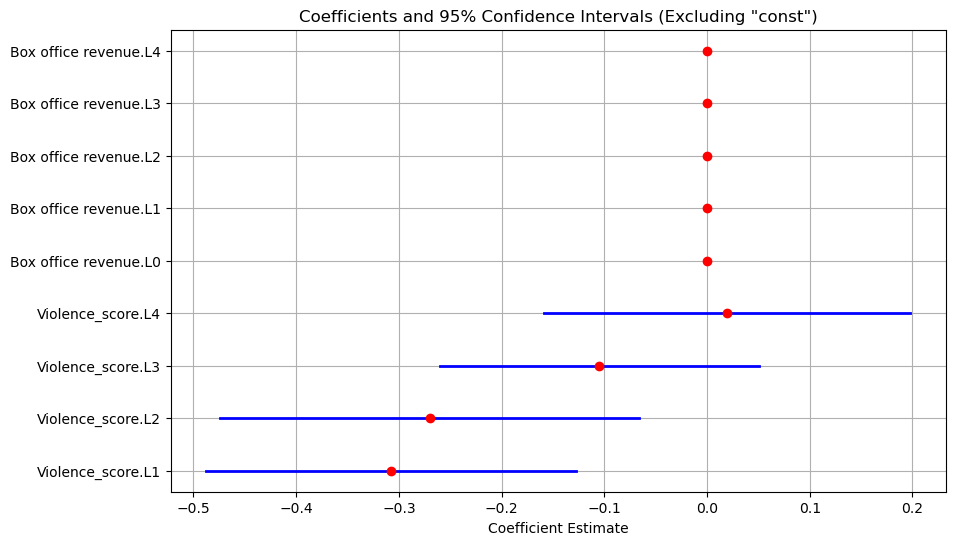

In [25]:
# Plot the 95% confidence intervals for all important coefficients
plot_coefficients_with_confidence_intervals(results_1_with_TFE_all_states)

#### All states merged without time-fixed effects:

In [29]:
# create ARDL model with optimal lags and exclude time-fixed effects
model_1_without_TFE_all_states = ARDL_model_func(df_box_offices, df_real_violence_cut, time_fixed_effects=False)

In [31]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_1_without_TFE_all_states = extract_model_results(model_1_without_TFE_all_states, "Model 1 without TFE all states", "data/CLEAN/")

In [34]:
# plot the summary of the fitted model (if needed)
#model_1_without_TFE_all_states.summary()

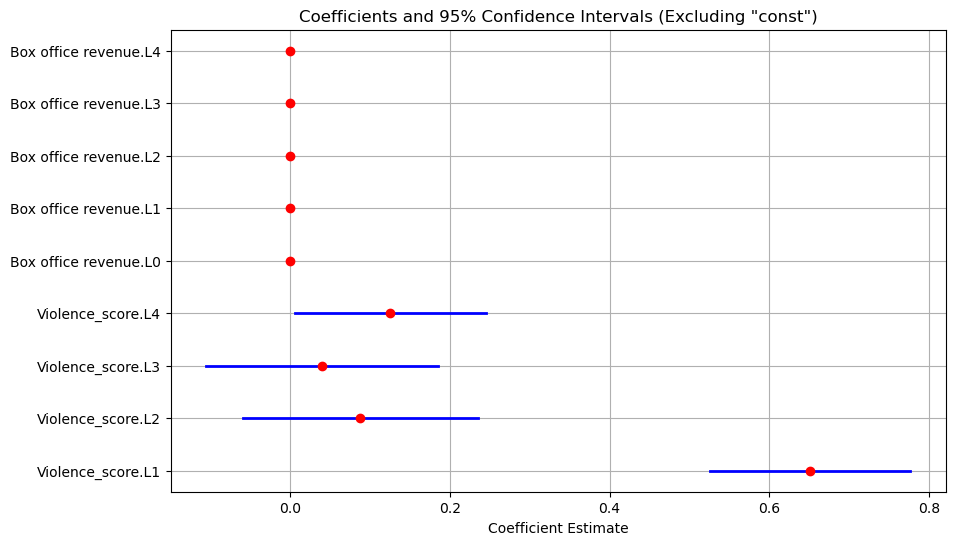

In [35]:
plot_coefficients_with_confidence_intervals(results_1_without_TFE_all_states)

#### Single state (example here: North Dakota) with time-fixed effects:

In [47]:
# retrieve info about the years for each state for which we have consecutive data
consecutive_years_per_state = pd.read_csv(DATA_PATH_ARDL+"/FBI_91_12/02_Consecutive_Years_States/Consecutive_years_states.tsv", sep="\t")

In [46]:
# fit an optimal ARDL model for each state separately, based on the corresponding consecutive years of data, with time-fixed effects
DIRECTORY_PATH = DATA_PATH_ARDL + "/FBI_91_12/01_States_Separately"
fitted_ARDL_models = ARDL_states_separate(DIRECTORY_PATH, df_box_offices, consecutive_years_per_state, ARDL_model_func, time_fixed_effects=True)

In [48]:
# choose one state of interest -> example here: North Dakota (feel free to choose another one)
model_1_with_TFE_single_state = fitted_ARDL_models["ARDL_NorthDakota"]

In [49]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_1_with_TFE_single_state = extract_model_results(model_1_with_TFE_single_state, "Model 1 with TFE single state", "data/CLEAN/")

In [50]:
# plot the summary of the fitted model (if needed)
#model_1_with_TFE_single_state.summary()

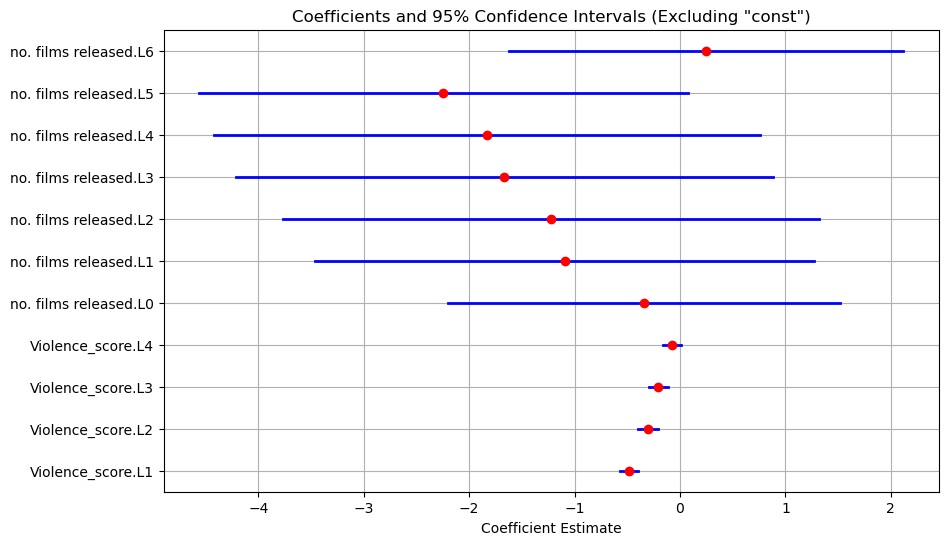

In [51]:
plot_coefficients_with_confidence_intervals(results_1_with_TFE_single_state)

#### Single state (example here: North Dakota) without time-fixed effects:

In [52]:
# fit an optimal ARDL model for each state separately, based on the corresponding consecutive years of data, without time-fixed effects
fitted_ARDL_models = ARDL_states_separate(DIRECTORY_PATH, df_box_offices, consecutive_years_per_state, ARDL_model_func, time_fixed_effects=False)

In [53]:
# choose one state of interest -> example here: North Dakota (feel free to choose another one)
model_1_without_TFE_single_state = fitted_ARDL_models["ARDL_NorthDakota"]

In [54]:
# extract the fitted model summary data, return the results dataframe and also store as HTML table (inside function) for embedding into website
results_1_without_TFE_single_state = extract_model_results(model_1_without_TFE_single_state, "Model 1 without TFE single state", "data/CLEAN/")

In [56]:
# plot the summary of the fitted model (if needed)
#model_1_without_TFE_single_state.summary()

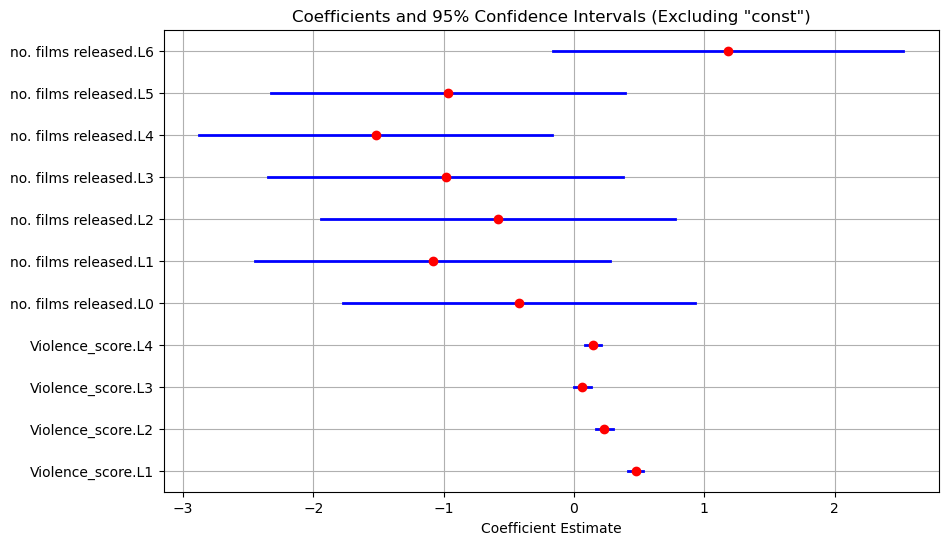

In [57]:
plot_coefficients_with_confidence_intervals(results_1_without_TFE_single_state)

### Model 2: Violence Offense Ratios

In the second approach, we normalize the real-world violence but keep the box office revenues as they are: 

* box office: sum of box office revenues of violent movies released in week i
* violent movie release count: count of violent movies released in week i
* real violence: number of all criminal offenses registered in week i divided by number of all criminal offenses registered in that year

*Note: Due to the analogous proceeding for all cases (all states/single state, with time-fixed effects/without time-fixed effects) we only show here the results for the example single state North Dakota, since we then can use a longer time period as for all states merged. North Dakota is particularly interesting since we have nearly complete data for 1991 to 2012.*

#### Single state (example here: North Dakota) with time-fixed effects:

In [4]:
temp = violence_score_all_states_count(directory_path = DATA_PATH_ARDL+"/FBI_91_12/03_Violence_Ratio/TEMP", start_year = 1991, end_year = 2012, start_week = 1, stop_week = 52, ratio = True)

In [5]:
temp

,Year,Week,Violence_score
0,1991,1,0.019231
1,1991,2,0.019231
2,1991,3,0.019231
3,1991,4,0.019231
4,1991,5,0.019231
...,...,...,...
1139,2012,48,0.019231
1140,2012,49,0.019231
1141,2012,50,0.019231
1142,2012,51,0.019231
